<a href="https://colab.research.google.com/github/JulesCollenne/MelanomaAsymmetry/blob/main/M%C3%A9lanomeMultiModal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce notebook, nous allons voir comment fusionner deux classifieurs selon plusieurs méthodes afin de résoudre des problèmes de multimodalité. La multimodalité consiste à utiliser des informations ayant différentes représentations afin de créer un unique classifieur capable de comprendre les différentes représentations.

# Setup

In [ ]:
%%capture
!unzip /content/drive/MyDrive/ISIC_2019.zip

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.preprocessing
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.applications.efficientnet import *
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from os import listdir
from os.path import isfile, join
from os import listdir
import cv2
from tensorflow.keras import Model

In [ ]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from scipy.stats import kurtosis, skew
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_auc_score
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow.keras
import os
from shapely.geometry import LineString
from shapely.geometry import Point
import sklearn
import sklearn.preprocessing
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage
from sklearn.metrics import roc_curve
import scipy.fft
from numpy.fft import fftshift
from google.colab.patches import cv2_imshow
from sklearn.decomposition import PCA
import math
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST
from functools import cmp_to_key
import logging
from os.path import isfile, join
from os import listdir
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from tensorflow.keras.layers import Lambda
from random import randrange
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

In [ ]:
def visu_results(y_test, predictions, normalize=None, confidence=None):
  y_test = np.asarray(y_test)
  if len(y_test.shape) == 1:
    y_testOH = tensorflow.keras.utils.to_categorical(y_test)
  else:
    y_testOH = y_test
  if len(predictions.shape) == 1:
    predictions = tensorflow.keras.utils.to_categorical(predictions)
  cm = confusion_matrix(np.argmax(y_testOH, axis=1), np.argmax(predictions, axis=1), normalize=normalize)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                    display_labels=('Melanome', 'Naevus'))
  disp.plot()
  print(classification_report(np.argmax(y_testOH, axis=1),
                            np.argmax(predictions, axis=1),
                            target_names=('Mélanome', 'Naevus')))
  if confidence is None:
    print('ROC score on test set : ',roc_auc_score(y_testOH, predictions))
    fpr, tpr, thresh = roc_curve(np.asarray(y_testOH)[:,0], np.asarray(predictions)[:,0])
  else:
    print('ROC score on test set : ',roc_auc_score(y_test, confidence))
    fpr, tpr, thresh = roc_curve(np.argmax(np.asarray(y_test), axis=1), np.asarray(confidence)[:,1])
  auc_keras = auc(fpr, tpr)
  plt.show()
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='lower right')
  plt.xlim([-0.01,1.01])
  plt.ylim([-0.01,1.01])
  plt.show()

def plot_hist(hist, metrics='accuracy'):
  plt.plot(hist.history[metrics], label=metrics)
  plt.plot(hist.history['val_'+metrics], label = 'val_'+metrics)
  plt.xlabel('Epoch')
  plt.ylabel(metrics)
  plt.legend(loc='lower right')

def run_and_test(featuresNames, parameters, clf, scoring = 'roc_auc', hasConfidence=False, centering=False):
  print('Loading features...')
  loader = DataLoader(featuresNames)
  X_train, y_train, X_test, y_test = loader.load()
  print('GridSeach...')
  gs = GridSearchCV(clf, parameters, scoring=scoring, n_jobs=-1, verbose=10).fit(X_train, y_train)

  print(gs.best_score_)
  print(gs.best_estimator_)
  clf = gs.best_estimator_

  print('Best estimator...')
  clf.fit(X_train, y_train)

  predictions = clf.predict(X_test)
  if hasConfidence:
    confidence = clf.decision_function(X_test)
    visu_results(y_test, predictions, confidence=confidence)
  else:
    visu_results(y_test, predictions)

  print('Cross_val_score (auc):',np.mean(cross_val_score(clf, X_train, y_train, scoring=scoring)))

def CNN_predict(model, dataset):
  y_true = []
  y_pred = []
  for X, y in dataset:
    y_true += y.numpy().tolist()
    y_pred += model(X).numpy().tolist()
  return y_true, y_pred

In [ ]:
class DataLoader():
  def __init__(self, featuresNames, featuresPath='/content/drive/MyDrive/Stage_LIS/Features/', scaler=sklearn.preprocessing.MinMaxScaler):
    self.names = featuresNames
    self.path = featuresPath
    self.scaler = scaler

  def load(self, normalize=True, centering=False):
    featuresPath = self.path
    featuresNames = self.names
    scaler = self.scaler()
    X_trainL = []
    X_testL = []
    y_train = np.loadtxt(featuresPath+'y_train.txt')
    y_test = np.loadtxt(featuresPath+'y_test.txt')
    if type(featuresNames) != str:
      for feature in featuresNames:
        xtrain = np.loadtxt(featuresPath+'X_train_'+feature+'.txt')
        xtest = np.loadtxt(featuresPath+'X_test_'+feature+'.txt')
        if normalize:
          scaler.fit(xtrain)
          xtrain = scaler.transform(xtrain)
          xtest = scaler.transform(xtest)
        if centering:
          xtrain -= 0.5
          xtest -= 0.5
        X_trainL.append(xtrain)
        X_testL.append(xtest)
      X_train = np.concatenate([elt for elt in X_trainL], axis=1)
      X_test = np.concatenate([elt for elt in X_testL], axis=1)
    else:
      datas = np.loadtxt(featuresPath+'X_train_'+featuresNames+'.txt')
      scaler.fit(datas)
      X_train = scaler.transform(datas)
      X_test = scaler.transform(np.loadtxt(featuresPath+'X_test_'+featuresNames+'.txt'))
    return X_train, y_train, X_test, y_test

# Définition des modèles

## Handcrafted features ANN

In [ ]:
def get_features():
  ohe = OneHotEncoder()

  featuresNames = ['beta_quad_RGB', 'beta_quad_HSV', 'beta_quad_Lab', 'beta_quad_YCrCb',
                  'histos', 'histos_HSV', 'histos_Lab', 'histos_YCrCb',
                  'SPML_4_2', 'SPML_4_2_HSV', 'SPML_4_2_cielab', 'SPML_4_2_ycbcr'
                  ,'SPO', 'SP60_4']

  loader = DataLoader(featuresNames)
  X_train, y_train, X_test, y_test = loader.load(centering=True)

  ohe.fit(y_train.reshape((-1, 1)))
  y_trainOH = ohe.transform(y_train.reshape((-1, 1))).toarray()
  y_testOH = ohe.transform(y_test.reshape((-1, 1))).toarray()
  return X_train, y_trainOH, X_test, y_testOH

def get_HCANN():
  model = Sequential()
  #model.add(Dense(32, activation='relu'))
  model.add(Dense(16, input_dim=714, activation='relu')) # input_dim = taille d'entrée
  model.add(Dropout(0.2))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC'])
  return model

X_trainANN, y_trainANN, X_testANN, y_testANN = get_features()

In [ ]:
hcann = get_HCANN()

epochs = 50
batch_size = 64
class_weight = {0:4.59, 1:1}
validation_split = 0.2

idx = np.random.permutation(len(X_trainANN))
X_trainANN2,y_trainANN2 = X_trainANN[idx], y_trainANN[idx]

history = hcann.fit(X_trainANN2, y_trainANN2, epochs=epochs, batch_size=batch_size, class_weight=class_weight, validation_split=validation_split, shuffle=True, workers=-1)
plot_hist(history, metrics='auc')

In [ ]:
y_predANN = hcann.predict(X_testANN)
visu_results(y_testANN, y_predANN, confidence=y_predANN)

In [ ]:
#hcann.save_weights('/content/drive/MyDrive/Stage_LIS/Weights/hcann.h5')

## CNN

In [ ]:
scal_size = 600 # taille de l'image
img_size = (scal_size,scal_size)
img_dim = (scal_size,scal_size,3)
batch_size = 16

def get_datasets(folder='NON_SEGMENTEES'):
  train_folder = '/TRAIN'
  train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/ISIC_2019/'+folder+train_folder,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical')

  val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/ISIC_2019/'+folder+train_folder,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical')

  test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/ISIC_2019/'+folder+'/TEST',
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    seed=123)
  return train_ds, val_ds, test_ds

In [ ]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.8),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.5),
    ],
    name="img_augmentation",
)

name2size = {
    'b0' : 224,
    'b1' : 240,
    'b2' : 260,
    'b3' : 300,
    'b4' : 380,
    'b5' : 456,
    'b6' : 528,
    'b7' : 600,
}

name2model = {
    'b0' : EfficientNetB0,
    'b1' : EfficientNetB1,
    'b2' : EfficientNetB2,
    'b3' : EfficientNetB3,
    'b4' : EfficientNetB4,
    'b5' : EfficientNetB5,
    'b6' : EfficientNetB6,
    'b7' : EfficientNetB7,
}

names = ('b0', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7')

def get_img_augmentation(size):
  return Sequential(
    [
        preprocessing.Resizing(size, size),
        preprocessing.RandomRotation(factor=0.8),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.5),
    ],
    name="img_augmentation",
  )

def get_efficientnet(model_name):
  size = name2size[model_name]

  inputs = layers.Input(shape=(None, None, 3))
  x = get_img_augmentation(size)(inputs)

  model = name2model[model_name](include_top=False, input_tensor=x, weights="imagenet")

  # Freeze the pretrained weights
  model.trainable = False

  # Rebuild top
  x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
  x = layers.BatchNormalization()(x)

  top_dropout_rate = 0.2
  x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  outputs = layers.Dense(2, activation="softmax", name="pred")(x)

  # Compile
  model = tf.keras.Model(inputs, outputs, name="EfficientNet")
  model.compile(
    optimizer='adam', loss="binary_crossentropy", metrics='AUC'
  )
  return model

In [ ]:
mypath = '/content/ISIC_2019/NON_SEGMENTEES/TEST/MEL'
files = [join(mypath,f) for f in listdir(mypath) if isfile(join(mypath,f))]
img = plt.imread(files[4])
plt.axis('off')
plt.imshow(img)
plt.pause(0.05)
img = np.expand_dims(img, 0)
img = img_augmentation(img)
img = np.squeeze(img)
plt.axis('off')
plt.imshow(img)

In [ ]:
mypath = '/content/ISIC_2019/NON_SEGMENTEES/TEST/NEV/ISIC_0025555.JPG'
#files = [join(mypath,f) for f in listdir(mypath) if isfile(join(mypath,f))]
img = plt.imread(mypath)
plt.axis('off')
plt.imshow(img)
plt.pause(0.05)
img = np.expand_dims(img, 0)
img = img_augmentation(img)
img = np.squeeze(img)
plt.axis('off')
plt.imshow(img)

In [ ]:
b2 = get_efficientnet('b2')
train_ds, val_ds, test_ds = get_datasets()
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

In [ ]:
b2 = get_efficientnet('b2')
b2.fit(train_ds, validation_data=val_ds, epochs=15, class_weight={0:4.59,1:1})
#b2.save_weights('/content/drive/MyDrive/Stage_LIS/Weights/'+name+'.h5')

Il reste à faire ceux là

In [ ]:
names = ('b6', 'b7')
for name in names:
  cnn = get_efficientnet(name)
  cnn.fit(train_ds, validation_data=val_ds, epochs=15, class_weight={0:4.59,1:1})
  cnn.save_weights('/content/drive/MyDrive/Stage_LIS/Weights/'+name+'.h5')

In [ ]:
weights_path = '/content/drive/MyDrive/Stage_LIS/Weights/'
b2.load_weights(weights_path+'b2.h5')

In [ ]:
def CNN_predict(model, dataset):
  y_true = []
  y_pred = []
  for X, y in dataset:
    y_true += y.numpy().tolist()
    y_pred += model(X).numpy().tolist()
  return y_true, y_pred

In [ ]:
y_testCNN, y_predCNN = CNN_predict(b2, test_ds)
visu_results(y_testCNN, np.asarray(y_predCNN), confidence=np.asarray(y_predCNN))

In [ ]:
b2.trainable = True

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
b2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='AUC')
b2.fit(train_ds, epochs=5, class_weight={0:4.59, 1:1}, validation_data=val_ds)

In [ ]:
y_testCNN, y_predCNN = CNN_predict(b2, test_ds)
visu_results(y_testCNN, np.asarray(y_predCNN), confidence=np.asarray(y_predCNN))

Fine pour dire fine tuné : Training sans couches freeze

In [ ]:
#b2.save_weights('/content/drive/MyDrive/Stage_LIS/Weights/b2_fine.h5')

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

In [ ]:
names = ('b6', 'b7')
weights_path = '/content/drive/MyDrive/Stage_LIS/Weights/'

name2size = {
    'b0' : 224,
    'b1' : 240,
    'b2' : 260,
    'b3' : 300,
    'b4' : 380,
    'b5' : 300,
    'b6' : 240,
    'b7' : 300,
}

for name in names:
  model = get_efficientnet(name)
  model.load_weights(weights_path+name+'.h5')
  model.trainable = True
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='AUC')
  model.fit(train_ds, batch_size=1, epochs=5, class_weight={0:4.59, 1:1}, validation_data=val_ds)
  model.save_weights(weights_path+name+'_fine.h5')

# Chargement des modèles

## ANN

In [ ]:
def get_features():
  ohe = OneHotEncoder()

  featuresNames = ['beta_quad_RGB', 'beta_quad_HSV', 'beta_quad_Lab', 'beta_quad_YCrCb',
                  'histos', 'histos_HSV', 'histos_Lab', 'histos_YCrCb',
                  'SPML_4_2', 'SPML_4_2_HSV', 'SPML_4_2_cielab', 'SPML_4_2_ycbcr',
                  'SPO', 'SP60_4']

  loader = DataLoader(featuresNames)
  X_train, y_train, X_test, y_test = loader.load(centering=True)

  ohe.fit(y_train.reshape((-1, 1)))
  y_trainOH = ohe.transform(y_train.reshape((-1, 1))).toarray()
  y_testOH = ohe.transform(y_test.reshape((-1, 1))).toarray()
  return X_train, y_trainOH, X_test, y_testOH

def get_HCANN():
  model = Sequential()
  #model.add(Dense(32, activation='relu'))
  model.add(Dense(16, input_dim=714, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC'])
  return model

X_trainANN, y_trainANN, X_testANN, y_testANN = get_features()

In [ ]:
hcann = get_HCANN()
hcann.load_weights('/content/drive/MyDrive/Stage_LIS/Weights/hcann.h5')

              precision    recall  f1-score   support

    Mélanome       0.37      0.90      0.52       273
      Naevus       0.97      0.67      0.79      1260

    accuracy                           0.71      1533
   macro avg       0.67      0.78      0.66      1533
weighted avg       0.86      0.71      0.74      1533

ROC score on test set :  0.8733865341008199


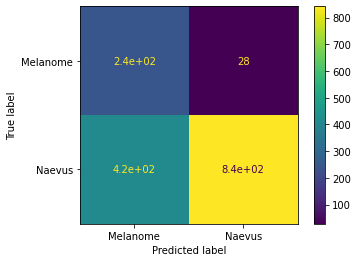

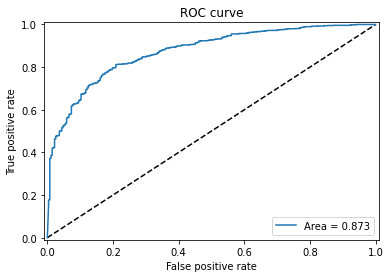

In [ ]:
y_predANN = hcann.predict(X_testANN)
visu_results(y_testANN, y_predANN, confidence=y_predANN)

## CNN

In [ ]:
scal_size = 600
img_size = (scal_size,scal_size)
img_dim = (scal_size,scal_size,3)
batch_size = 16

def get_datasets(folder='NON_SEGMENTEES'):
  train_folder = '/TRAIN'
  train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/ISIC_2019/'+folder+train_folder,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical')

  val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/ISIC_2019/'+folder+train_folder,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical')

  test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/ISIC_2019/'+folder+'/TEST',
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    seed=123)
  return train_ds, val_ds, test_ds

In [ ]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.8),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.5),
    ],
    name="img_augmentation",
)

name2size = {
    'b0' : 224,
    'b1' : 240,
    'b2' : 260,
    'b3' : 300,
    'b4' : 380,
    'b5' : 456,
    'b6' : 528,
    'b7' : 600,
}

name2model = {
    'b0' : EfficientNetB0,
    'b1' : EfficientNetB1,
    'b2' : EfficientNetB2,
    'b3' : EfficientNetB3,
    'b4' : EfficientNetB4,
    'b5' : EfficientNetB5,
    'b6' : EfficientNetB6,
    'b7' : EfficientNetB7,
}

names = ('b0', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7')

def get_img_augmentation(size):
  return Sequential(
    [
        preprocessing.Resizing(size, size),
        preprocessing.RandomRotation(factor=0.8),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.5),
    ],
    name="img_augmentation",
  )

def get_efficientnet(model_name):
  size = name2size[model_name]

  inputs = layers.Input(shape=(None, None, 3))
  x = get_img_augmentation(size)(inputs)

  model = name2model[model_name](include_top=False, input_tensor=x, weights="imagenet")

  # Freeze the pretrained weights
  model.trainable = False

  # Rebuild top
  x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
  x = layers.BatchNormalization()(x)

  top_dropout_rate = 0.2
  x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  outputs = layers.Dense(2, activation="softmax", name="pred")(x)

  # Compile
  model = tf.keras.Model(inputs, outputs, name="EfficientNet")
  model.compile(
    optimizer='adam', loss="binary_crossentropy", metrics='AUC'
  )
  return model

In [ ]:
train_ds, val_ds, test_ds = get_datasets()
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Found 6124 files belonging to 2 classes.
Using 4900 files for training.
Found 6124 files belonging to 2 classes.
Using 1224 files for validation.
Found 1533 files belonging to 2 classes.
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



In [ ]:
weights_path = '/content/drive/MyDrive/Stage_LIS/Weights/'
b2 = get_efficientnet('b2')
b2.load_weights(weights_path+'b2_fine.h5')

31801344/31790344 [==============================] - 1s 0us/step


In [ ]:
def CNN_predict(model, dataset):
  y_true = []
  y_pred = []
  for X, y in dataset:
    y_true += y.numpy().tolist()
    y_pred += model(X).numpy().tolist()
  return y_true, y_pred

In [ ]:
#y_testCNN, y_predCNN = CNN_predict(b2, test_ds)
#visu_results(y_testCNN, np.asarray(y_predCNN), confidence=np.asarray(y_predCNN))

# 1. Early fusion

Cette fusion nécessite une quantité astronomique de ressource de calcul. De ce fait, les expériences suivantes sont développées en conséquence afin que le code puisse fonctionner. L'ANN est extrêmement petit, la taille de batch est minuscule, ce qui donne forcément des résultats médiocres. Ainsi cette piste n'est pas à poursuivre

## Chargement des données

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Stage_LIS/train_files.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Stage_LIS/test_files.csv')

featuresNames = ['beta_quad_RGB', 'beta_quad_HSV', 'beta_quad_Lab', 'beta_quad_YCrCb',
                'histos', 'histos_HSV', 'histos_Lab', 'histos_YCrCb',
                'SPML_4_2', 'SPML_4_2_HSV', 'SPML_4_2_cielab', 'SPML_4_2_ycbcr',
                'SPO', 'SP60_4']

loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load(centering=True)

In [ ]:
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, df, features,
                 batch_size, val_split=0.,
                 shuffle=True, is_val=False):
        if val_split > 0:
            if is_val == False:
                self.df = df.copy()[:-int(len(df)*0.2)]
            else:
                self.df = df.copy()[int(len(df)*0.2):]
        else:
            self.df = df.copy()
        self.features = features
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n = len(self.df)
        self.num_classes = 2

    def on_epoch_end(self):
        if self.shuffle:
            self.df.sample(frac=1).reset_index(drop=True)

    def __get_input(self, path):
        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = tf.keras.preprocessing.image.smart_resize(image_arr, img_size)
        return image_arr

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batches = self.df[start:end]
        names = batches['Name']
        images = [self.__get_input(img) for img in names]
        hc_features = [self.features[i] for i in batches['Loc']]
        y = tf.keras.utils.to_categorical(batches['Label'], num_classes=2)
        images = np.asarray(images)
        hc_features = np.asarray(hc_features)
        images = np.reshape(images, (self.batch_size, scal_size*scal_size*3))
        return np.concatenate((images, hc_features), axis=1), y
        #return [tf.Tensor(images, shape=(n)), tf.Tensor(hc_features)], y
        #return [images, hc_features], y
        #return images, y
    
    def __len__(self):
        return self.n // self.batch_size

In [ ]:
batch_size = 1
traingen = CustomDataGen(train_df, X_train, val_split=0.2,
                         batch_size=batch_size)

valgen = CustomDataGen(train_df, X_train, val_split=0.2, is_val=True,
                         batch_size=batch_size)

testgen = CustomDataGen(test_df, X_test,
                         batch_size=batch_size)

## Modèle et entrainement

In [ ]:
def get_ANN():
  model = Sequential()
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC'])
  return model

Epoch 1/5
4900/4900 [==============================] - 299s 61ms/step - loss: 172609.0938 - auc: 0.6631 - val_loss: 608144.6875 - val_auc: 0.0788
Epoch 2/5
4900/4900 [==============================] - 247s 50ms/step - loss: 178836.2656 - auc: 0.6882 - val_loss: 30282.7715 - val_auc: 0.8420
Epoch 3/5
4900/4900 [==============================] - 255s 52ms/step - loss: 175632.1719 - auc: 0.6945 - val_loss: 26153.0879 - val_auc: 0.8567
Epoch 4/5
4900/4900 [==============================] - 251s 51ms/step - loss: 168246.7188 - auc: 0.7020 - val_loss: 194113.8750 - val_auc: 0.5086
Epoch 5/5
4900/4900 [==============================] - 250s 51ms/step - loss: 169754.7969 - auc: 0.6996 - val_loss: 505135.2812 - val_auc: 0.1800


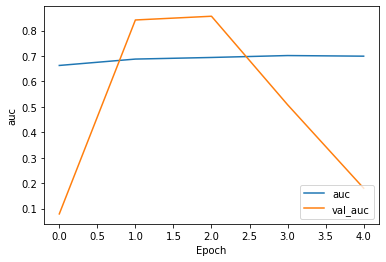

In [ ]:
ann = get_ANN()

epochs = 5
batch_size = 1
class_weight = {0:4.59, 1:1}
validation_split = 0.2

history = ann.fit(traingen, epochs=epochs, batch_size=batch_size, class_weight=class_weight, validation_data=valgen, shuffle=True, workers=-1)
plot_hist(history, metrics='auc')

In [ ]:
def CNN_predict(model, dataset):
  y_true = []
  y_pred = []
  for X, y in dataset:
    y_true += y.tolist()
    y_pred += model(X).numpy().tolist()
  return y_true, y_pred

y_test, predictions = CNN_predict(ann, testgen)

visu_results(np.asarray(y_test), np.asarray(predictions), confidence=np.asarray(predictions))

              precision    recall  f1-score   support

    Mélanome       0.21      1.00      0.35       273
      Naevus       1.00      0.19      0.32      1260

    accuracy                           0.33      1533
   macro avg       0.61      0.59      0.33      1533
weighted avg       0.86      0.33      0.32      1533

ROC score on test set :  0.5944444444444444


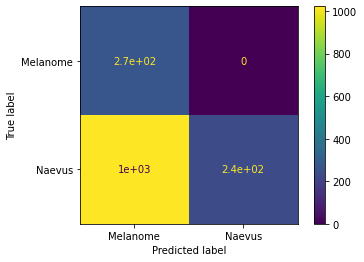

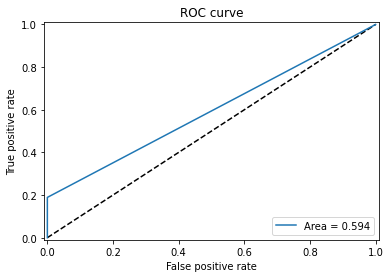

In [ ]:
visu_results(np.asarray(y_test), np.asarray(predictions), confidence=np.asarray(predictions))

In [ ]:
#ann.save_weights('/content/drive/MyDrive/Stage_LIS/Weights/hcann.h5')

# 2. Late fusion

La late fusion consiste à réaliser la fusion au dernier moment : Après la prédiction. La méthodologie est la suivante : 

1.   Construire et entrainer les deux réseaux indépendemment
2.   Pour la prédiction, les faire prédire séparemment : Pour une même instance, le CNN prend l'image tandis que l'ANN prends les autres informations.
3. Une fois le score de prédiction de chaque instance calculé, fusionner ces deux prédictions. Il y a plusieurs manière de faire cela : 

*   Faire la moyenne des scores
*   Faire la moyenne pondérée des score (en fonction des performance des classifieurs)
*   D'autres calculs







In [ ]:
def load_test_set_multimodal():
  base = '/content/ISIC_2019/'
  folder = 'TEST/'
  path = base+'NON_SEGMENTEES/'+folder
  X_testCNN = []
  for lesion_type in ('MEL', 'NEV'):
    current_path = path+lesion_type+'/'
    files = sorted([f for f in listdir(current_path) if isfile(join(current_path,f))])
    for file in files:
      img = cv2.resize(cv2.imread(current_path+file), img_size)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      X_testCNN.append(img)
  return np.asarray(X_testCNN)

def late_fusion(predictions, weights=None):
  return np.mean([predictions[i] * weights[i] for i in range(len(predictions))], axis=0)

In [ ]:
X_testCNN = load_test_set_multimodal()

Résultat de B2 tout seul

              precision    recall  f1-score   support

    Mélanome       0.52      0.81      0.63       273
      Naevus       0.95      0.84      0.89      1260

    accuracy                           0.83      1533
   macro avg       0.74      0.82      0.76      1533
weighted avg       0.88      0.83      0.85      1533

ROC score on test set :  0.9053346124774696


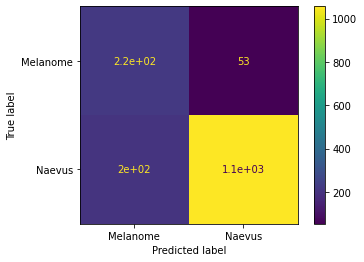

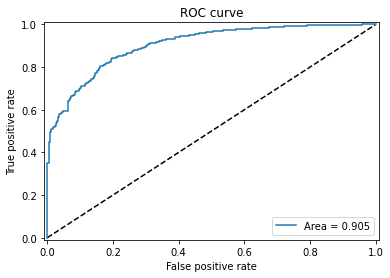

In [ ]:
y_pred = b2.predict(X_testCNN)
visu_results(y_testANN, y_pred, confidence=y_pred)

In [ ]:
predictions = []
predictions.append(hcann.predict(X_testANN))
predictions.append(b2.predict(X_testCNN))

Late fusion avec poids de 1 pour les deux

              precision    recall  f1-score   support

    Mélanome       0.48      0.85      0.62       273
      Naevus       0.96      0.80      0.88      1260

    accuracy                           0.81      1533
   macro avg       0.72      0.83      0.75      1533
weighted avg       0.88      0.81      0.83      1533

ROC score on test set :  0.9158904587476016


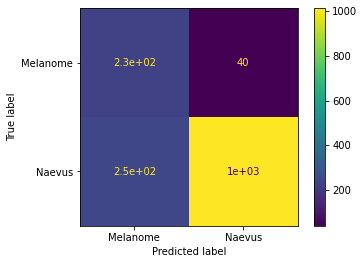

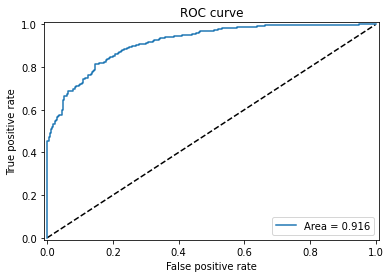

In [ ]:
weights = (1,1)
y_pred = late_fusion(predictions, weights=weights)
visu_results(y_testANN, y_pred, confidence=y_pred)

On a donc un score meilleur que les deux modèles choisis indépendemment. Il est toutefois important de noter que le CNN a encore une couche d'image augmentation qui peut faire varier les scores de prédiction (car l'image augmentation est executée sur les données test). Il est possible de supprimer cette couche, mais les résultats ne semble pas très affectés.

Avec un seuil

              precision    recall  f1-score   support

    Mélanome       0.42      0.88      0.57       273
      Naevus       0.97      0.73      0.83      1260

    accuracy                           0.76      1533
   macro avg       0.69      0.81      0.70      1533
weighted avg       0.87      0.76      0.79      1533



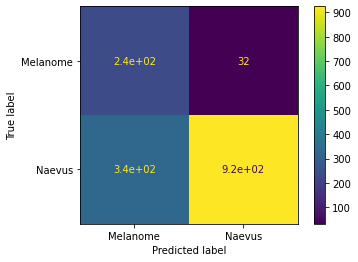

In [ ]:
seuil = 0.5
cm = confusion_matrix(np.argmax(y_testANN, axis=1), [0 if pred[0] > seuil else 1 for pred in y_pred])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=('Melanome', 'Naevus'))
disp.plot()

print(classification_report(np.argmax(y_testANN, axis=1),
                          [0 if pred[0] > seuil else 1 for pred in y_pred],
                          target_names=('Mélanome', 'Naevus')))


In [ ]:
def get_features():
  ohe = OneHotEncoder()

  featuresNames = ['beta_quad_RGB', 'beta_quad_HSV', 'beta_quad_Lab', 'beta_quad_YCrCb',
                  'histos', 'histos_HSV', 'histos_Lab', 'histos_YCrCb',
                  'SPML_4_2', 'SPML_4_2_HSV', 'SPML_4_2_cielab', 'SPML_4_2_ycbcr',
                  'SPO', 'SP60_4', 'beta']

  loader = DataLoader(featuresNames)
  X_train, y_train, X_test, y_test = loader.load(centering=True)

  ohe.fit(y_train.reshape((-1, 1)))
  y_trainOH = ohe.transform(y_train.reshape((-1, 1))).toarray()
  y_testOH = ohe.transform(y_test.reshape((-1, 1))).toarray()
  return X_train, y_trainOH, X_test, y_testOH

def get_HCANN():
  model = Sequential()
  #model.add(Dense(32, activation='relu'))
  model.add(Dense(128, input_dim=729, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC'])
  return model

X_trainANN, y_trainANN, X_testANN, y_testANN = get_features()

Epoch 1/50
77/77 [==============================] - 1s 7ms/step - loss: 1.1449 - auc: 0.6265 - val_loss: 0.5922 - val_auc: 0.9101
Epoch 2/50
77/77 [==============================] - 0s 4ms/step - loss: 1.0583 - auc: 0.7179 - val_loss: 0.6449 - val_auc: 0.7042
Epoch 3/50
77/77 [==============================] - 0s 4ms/step - loss: 0.9519 - auc: 0.7736 - val_loss: 0.4695 - val_auc: 0.8922
Epoch 4/50
77/77 [==============================] - 0s 4ms/step - loss: 0.8941 - auc: 0.8116 - val_loss: 0.4720 - val_auc: 0.8823
Epoch 5/50
77/77 [==============================] - 0s 5ms/step - loss: 0.8693 - auc: 0.8106 - val_loss: 0.3706 - val_auc: 0.9216
Epoch 6/50
77/77 [==============================] - 0s 5ms/step - loss: 0.9065 - auc: 0.7964 - val_loss: 0.4543 - val_auc: 0.8715
Epoch 7/50
77/77 [==============================] - 0s 4ms/step - loss: 0.8396 - auc: 0.8188 - val_loss: 0.4230 - val_auc: 0.8940
Epoch 8/50
77/77 [==============================] - 0s 5ms/step - loss: 0.8339 - auc: 0.82

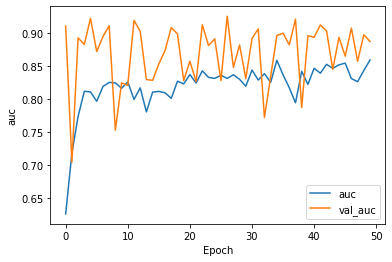

In [ ]:
hcann = get_HCANN()

epochs = 50
batch_size = 64
class_weight = {0:4.59, 1:1}
validation_split = 0.2

idx = np.random.permutation(len(X_trainANN))
X_trainANN2,y_trainANN2 = X_trainANN[idx], y_trainANN[idx]

history = hcann.fit(X_trainANN2, y_trainANN2, epochs=epochs, batch_size=batch_size, class_weight=class_weight, validation_split=validation_split, shuffle=True, workers=-1)
plot_hist(history, metrics='auc')

In [ ]:
predictions = []
predictions.append(hcann.predict(X_testANN))
predictions.append(b2.predict(X_testCNN))

              precision    recall  f1-score   support

    Mélanome       0.53      0.82      0.64       273
      Naevus       0.96      0.84      0.89      1260

    accuracy                           0.84      1533
   macro avg       0.74      0.83      0.77      1533
weighted avg       0.88      0.84      0.85      1533

ROC score on test set :  0.915884644456073


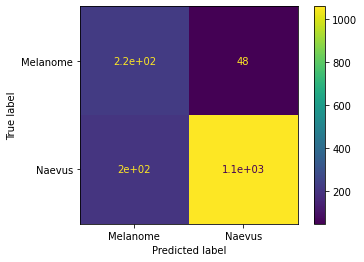

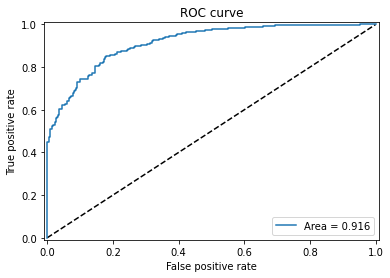

In [ ]:
weights = (1,1)
y_pred = late_fusion(predictions, weights=weights)
visu_results(y_testANN, y_pred, confidence=y_pred)

## Gradient boosting

Late fusion Gradient boosting + CNN

In [ ]:
from xgboost import XGBClassifier

hcann = XGBClassifier(n_estimators=1000, learning_rate=0.01)

featuresNames = ['beta_quad_RGB', 'beta_quad_HSV', 'beta_quad_Lab', 'beta_quad_YCrCb',
                'histos', 'histos_HSV', 'histos_Lab', 'histos_YCrCb',
                'SPML_4_2', 'SPML_4_2_HSV', 'SPML_4_2_cielab', 'SPML_4_2_ycbcr',
                'SPO', 'SP60_4']

loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load(centering=True)

sample_weight = [4.59 if i == 0 else 1 for i in y_train]

hcann.fit(np.asarray(X_train), y_train,
             verbose=False, eval_metric='auc', sample_weight=sample_weight)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
predictions = []
predictions.append(hcann.predict_proba(X_testANN))
predictions.append(b2.predict(X_testCNN))

              precision    recall  f1-score   support

    Mélanome       0.51      0.83      0.63       273
      Naevus       0.96      0.82      0.89      1260

    accuracy                           0.83      1533
   macro avg       0.73      0.83      0.76      1533
weighted avg       0.88      0.83      0.84      1533

ROC score on test set :  0.9142188499331356


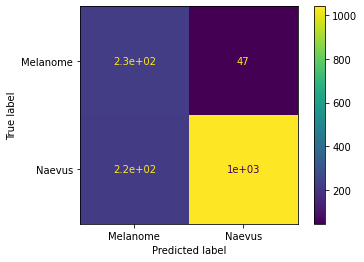

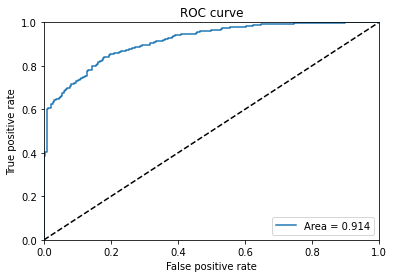

In [ ]:
weights = (1,1)
y_pred = late_fusion(predictions, weights=weights)
visu_results(y_testANN, y_pred, confidence=y_pred)

On a un résultat presque similaire, le GB fait légèrement plus d'erreurs sur les mélanomes mais moins sur les naevus.

# 3. Hybrid fusion

In [ ]:
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, df, features,
                 batch_size, val_split=0.,
                 shuffle=True, is_val=False):
        if val_split > 0:
            if is_val == False:
                self.df = df.copy()[:-int(len(df)*0.2)]
            else:
                self.df = df.copy()[int(len(df)*0.2):]
        else:
            self.df = df.copy()
        self.features = features
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n = len(self.df)
        self.num_classes = 2

    def on_epoch_end(self):
        if self.shuffle:
            self.df.sample(frac=1).reset_index(drop=True)

    def __get_input(self, path):
        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = tf.keras.preprocessing.image.smart_resize(image_arr, img_size)
        return image_arr

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batches = self.df[start:end]
        names = batches['Name']
        images = [self.__get_input(img) for img in names]# images
        hc_features = [self.features[i] for i in batches['Loc']]#données
        y = tf.keras.utils.to_categorical(batches['Label'], num_classes=2)
        images = np.asarray(images)
        hc_features = np.asarray(hc_features)
        #return [tf.Tensor(images, shape=(n)), tf.Tensor(hc_features)], y
        return [images, hc_features], y
        #return images, y
    
    def __len__(self):
        return self.n // self.batch_size

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Stage_LIS/train_files.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Stage_LIS/test_files.csv')

featuresNames = ['beta_quad_RGB', 'beta_quad_HSV', 'beta_quad_Lab', 'beta_quad_YCrCb',
                'histos', 'histos_HSV', 'histos_Lab', 'histos_YCrCb',
                'SPML_4_2', 'SPML_4_2_HSV', 'SPML_4_2_cielab', 'SPML_4_2_ycbcr',
                'SPO', 'SP60_4']

loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load(centering=True)

In [ ]:
traingen = CustomDataGen(train_df, X_train, val_split=0.2,
                         batch_size=32)

valgen = CustomDataGen(train_df, X_train, val_split=0.2, is_val=True,
                         batch_size=32)

testgen = CustomDataGen(test_df, X_test,
                         batch_size=32)

In [ ]:
hc_dim = X_trainANN.shape[1]

In [ ]:
def get_hybrid_model(cnn, hcnn):
  #cnn.pop()
  #hcnn.pop()
  cnn.trainable = False
  hcnn.trainable = False

  #combinedInput = concatenate([cnn.output, hcnn.output])
  combinedInput = concatenate([cnn.layers[-2].output, hcnn.layers[-2].output])

  # combinedInput = Dropout(0.1)(combinedInput)
  x = Dropout(0.5)(combinedInput)
  outputs = layers.Dense(2, activation="softmax", name="predFinal")(x)

  # Compile
  model = tf.keras.Model(inputs=[cnn.inputs, hcnn.inputs], outputs=outputs, name="HybridFusion")
  model.compile(
    optimizer='adam', loss="binary_crossentropy", metrics='AUC'
  )
  return model


hcann = get_HCANN()
hcann.load_weights('/content/drive/MyDrive/Stage_LIS/Weights/hcann.h5')

b2 = get_efficientnet('b2')
b2.load_weights(weights_path+'b2_fine.h5')

hybrid = get_hybrid_model(b2, hcann)

In [ ]:
epochs = 5
batch_size = 32
class_weight = {0:4.59, 1:1}

hist = hybrid.fit(traingen, validation_data=valgen, epochs=epochs, class_weight=class_weight)

Epoch 1/5
153/153 [==============================] - 212s 1s/step - loss: 0.9066 - auc: 0.7975 - val_loss: 0.6696 - val_auc: 0.7646
Epoch 2/5
153/153 [==============================] - 199s 1s/step - loss: 0.7642 - auc: 0.8596 - val_loss: 0.3689 - val_auc: 0.9184
Epoch 3/5
153/153 [==============================] - 199s 1s/step - loss: 0.7425 - auc: 0.8951 - val_loss: 0.5507 - val_auc: 0.8344
Epoch 4/5
153/153 [==============================] - 197s 1s/step - loss: 0.6170 - auc: 0.9001 - val_loss: 0.6684 - val_auc: 0.7872
Epoch 5/5
153/153 [==============================] - 198s 1s/step - loss: 0.6035 - auc: 0.9104 - val_loss: 0.4571 - val_auc: 0.8793


              precision    recall  f1-score   support

    Mélanome       0.45      0.90      0.60       273
      Naevus       0.97      0.76      0.85      1231

    accuracy                           0.78      1504
   macro avg       0.71      0.83      0.73      1504
weighted avg       0.88      0.78      0.81      1504

ROC score on test set :  0.9304892237467379


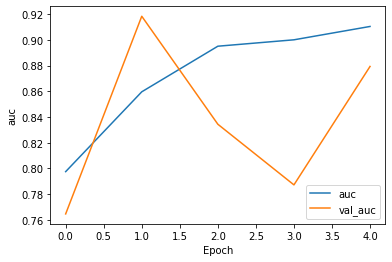

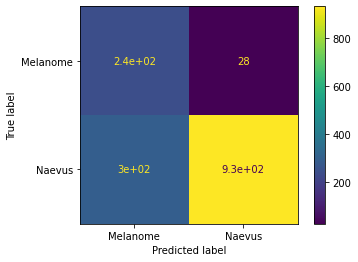

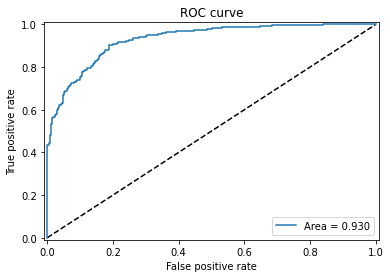

In [ ]:
def CNN_predict(model, dataset):
  y_true = []
  y_pred = []
  for X, y in dataset:
    y_true += y.tolist()
    y_pred += model(X).numpy().tolist()
  return y_true, y_pred

y_test, predictions = CNN_predict(hybrid, testgen)

plot_hist(hist, metrics='auc')
visu_results(np.asarray(y_test), np.asarray(predictions), confidence=np.asarray(predictions))

In [ ]:
def get_hybrid_model(cnn, hcnn):
  #cnn.pop()
  #hcnn.pop()
  cnn.trainable = False
  hcnn.trainable = False

  #combinedInput = concatenate([cnn.output, hcnn.output])
  combinedInput = concatenate([cnn.layers[-2].output, hcnn.layers[-2].output])
  x = Dense(16, activation="relu")(combinedInput)
  outputs = layers.Dense(2, activation="softmax", name="predFinal")(x)

  # Compile
  model = tf.keras.Model(inputs=[cnn.inputs, hcnn.inputs], outputs=outputs, name="HybridFusion")
  model.compile(
    optimizer='adam', loss="binary_crossentropy", metrics='AUC'
  )
  return model


hcann = get_HCANN()
hcann.load_weights('/content/drive/MyDrive/Stage_LIS/Weights/hcann.h5')

b2 = get_efficientnet('b2')
b2.load_weights(weights_path+'b2_fine.h5')

hybrid = get_hybrid_model(b2, hcann)
plot_model(hybrid)

KeyboardInterrupt: ignored

In [ ]:
epochs = 5
batch_size = 32
class_weight = {0:4.59, 1:1}

hist = hybrid.fit(traingen, validation_data=valgen, epochs=epochs, class_weight=class_weight, batch_size=batch_size)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/5
153/153 [==============================] - 225s 1s/step - loss: 0.8404 - auc: 0.8573 - val_loss: 0.5270 - val_auc: 0.7876
Epoch 2/5
153/153 [==============================] - 186s 1s/step - loss: 0.6215 - auc: 0.8939 - val_loss: 0.4854 - val_auc: 0.8075
Epoch 3/5
153/153 [==============================] - 186s 1s/step - loss: 0.5387 - auc: 0.9208 - val_loss: 0.4841 - val_auc: 0.8459
Epoch 4/5
153/153 [==============================] - 190s 1s/step - loss: 0.5284 - auc: 0.9249 - val_loss: 0.5432 - val_auc: 0.8074
Epoch 5/5
153/153 [==============================] - 189s 1s/step - loss: 0.5681 - auc: 0.9162 - val_loss: 0.5114 - val_auc: 0.8402


              precision    recall  f1-score   support

    Mélanome       0.37      0.93      0.53       273
      Naevus       0.98      0.65      0.78      1231

    accuracy                           0.70      1504
   macro avg       0.67      0.79      0.65      1504
weighted avg       0.87      0.70      0.73      1504

ROC score on test set :  0.9056903021159723


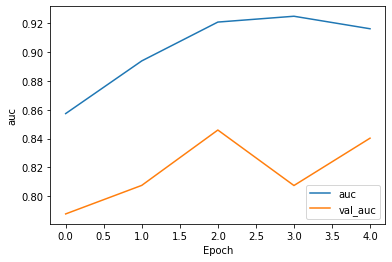

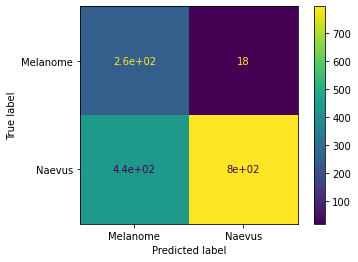

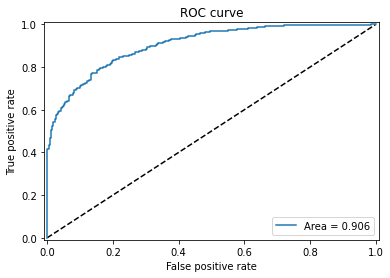

In [ ]:
def CNN_predict(model, dataset):
  y_true = []
  y_pred = []
  for X, y in dataset:
    y_true += y.tolist()
    y_pred += model(X).numpy().tolist()
  return y_true, y_pred

y_test, predictions = CNN_predict(hybrid, testgen)

plot_hist(hist, metrics='auc')
visu_results(np.asarray(y_test), np.asarray(predictions), confidence=np.asarray(predictions))

In [ ]:
epochs = 5
batch_size = 32
class_weight = {0:4.59, 1:1}

hist = hybrid.fit(traingen, validation_data=valgen, epochs=epochs, class_weight=class_weight, batch_size=batch_size)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/5
153/153 [==============================] - 269s 2s/step - loss: 0.8517 - auc: 0.8714 - val_loss: 0.6847 - val_auc: 0.7277
Epoch 2/5
153/153 [==============================] - 253s 2s/step - loss: 0.6185 - auc: 0.9092 - val_loss: 0.7999 - val_auc: 0.7293
Epoch 3/5
153/153 [==============================] - 253s 2s/step - loss: 0.5596 - auc: 0.9061 - val_loss: 0.3672 - val_auc: 0.9066
Epoch 4/5
153/153 [==============================] - 252s 2s/step - loss: 0.5495 - auc: 0.9141 - val_loss: 0.5293 - val_auc: 0.8305
Epoch 5/5
153/153 [==============================] - 249s 2s/step - loss: 0.5212 - auc: 0.9210 - val_loss: 0.4622 - val_auc: 0.8685


In [ ]:
def CNN_predict(model, dataset):
  y_true = []
  y_pred = []
  for X, y in dataset:
    y_true += y.tolist()
    y_pred += model(X).numpy().tolist()
  return y_true, y_pred

y_test, predictions = CNN_predict(hybrid, testgen)

              precision    recall  f1-score   support

    Mélanome       0.43      0.89      0.59       273
      Naevus       0.97      0.74      0.84      1231

    accuracy                           0.77      1504
   macro avg       0.70      0.82      0.71      1504
weighted avg       0.87      0.77      0.79      1504

ROC score on test set :  0.9091524505821824


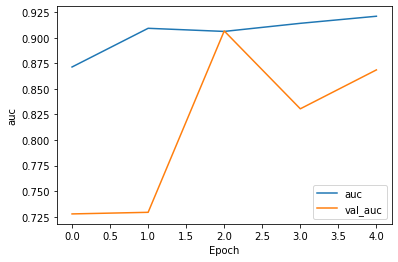

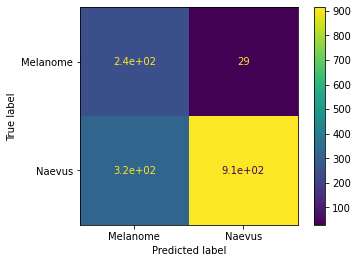

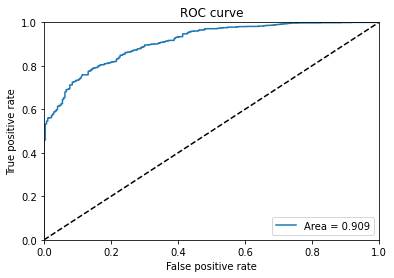

In [ ]:
plot_hist(hist, metrics='auc')
visu_results(np.asarray(y_test), np.asarray(predictions), confidence=np.asarray(predictions))

## Testtt

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Stage_LIS/train_files.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Stage_LIS/test_files.csv')

featuresNames = ['beta_quad_RGB', 'beta_quad_HSV', 'beta_quad_Lab', 'beta_quad_YCrCb',
                'histos', 'histos_HSV', 'histos_Lab', 'histos_YCrCb',
                'SPML_4_2', 'SPML_4_2_HSV', 'SPML_4_2_cielab', 'SPML_4_2_ycbcr',
                'SPO', 'SP60_4', 'beta']

loader = DataLoader(featuresNames)
X_train, y_train, X_test, y_test = loader.load(centering=True)

In [ ]:
traingen = CustomDataGen(train_df, X_train, val_split=0.2,
                         batch_size=64)

valgen = CustomDataGen(train_df, X_train, val_split=0.2, is_val=True,
                         batch_size=64)

testgen = CustomDataGen(test_df, X_test,
                         batch_size=64)

In [ ]:
def get_hybrid_model(cnn, hcnn):
  #cnn.pop()
  #hcnn.pop()
  cnn.trainable = False
  hcnn.trainable = False

  #combinedInput = concatenate([cnn.output, hcnn.output])
  combinedInput = concatenate([cnn.layers[-2].output, hcnn.layers[-2].output])

  combinedInput = Dropout(0.1)(combinedInput)
  x = Dense(64, activation="relu")(combinedInput)
  x = Dropout(0.2)(x)
  x = Dense(32, activation="relu")(combinedInput)
  x = Dropout(0.2)(x)
  x = Dense(16, activation="relu")(x)
  outputs = layers.Dense(2, activation="softmax", name="predFinal")(x)

  # Compile
  model = tf.keras.Model(inputs=[cnn.inputs, hcnn.inputs], outputs=outputs, name="HybridFusion")
  model.compile(
    optimizer='adam', loss="binary_crossentropy", metrics='AUC'
  )
  return model

hybrid = get_hybrid_model(b2, hcann)

In [ ]:
epochs = 10
batch_size = 64
class_weight = {0:4.59, 1:1}

hist = hybrid.fit(traingen, validation_data=valgen, epochs=epochs, class_weight=class_weight, batch_size=batch_size)

Epoch 1/10
76/76 [==============================] - 193s 3s/step - loss: 0.8310 - auc: 0.8023 - val_loss: 0.5290 - val_auc: 0.7404
Epoch 2/10
76/76 [==============================] - 188s 2s/step - loss: 0.5689 - auc: 0.9056 - val_loss: 0.5717 - val_auc: 0.7853
Epoch 3/10
76/76 [==============================] - 234s 3s/step - loss: 0.6802 - auc: 0.8879 - val_loss: 0.6308 - val_auc: 0.7558
Epoch 4/10
76/76 [==============================] - 189s 3s/step - loss: 0.5758 - auc: 0.8933 - val_loss: 0.5601 - val_auc: 0.8135
Epoch 5/10
76/76 [==============================] - 187s 2s/step - loss: 0.5675 - auc: 0.9183 - val_loss: 0.3916 - val_auc: 0.9013
Epoch 6/10
76/76 [==============================] - 187s 2s/step - loss: 0.5232 - auc: 0.9258 - val_loss: 0.3284 - val_auc: 0.9306
Epoch 7/10
76/76 [==============================] - 187s 2s/step - loss: 0.5302 - auc: 0.9303 - val_loss: 1.0113 - val_auc: 0.6844
Epoch 8/10
76/76 [==============================] - 187s 2s/step - loss: 0.4810 - a

In [ ]:
def CNN_predict(model, dataset):
  y_true = []
  y_pred = []
  for X, y in dataset:
    y_true += y.tolist()
    y_pred += model(X).numpy().tolist()
  return y_true, y_pred

y_test, predictions = CNN_predict(hybrid, testgen)

plot_hist(hist, metrics='auc')
visu_results(np.asarray(y_test), np.asarray(predictions), confidence=np.asarray(predictions))

## Tests

In [ ]:
def get_hybrid_model(cnn, hcnn):
  #cnn.pop()
  #hcnn.pop()
  cnn.trainable = False
  hcnn.trainable = False

  #combinedInput = concatenate([cnn.output, hcnn.output])
  combinedInput = concatenate([cnn.layers[-2].output, hcnn.layers[-2].output])

  #combinedInput = Dropout(0.1)(combinedInput)
  x = Dense(32, activation="relu")(combinedInput)
  x = Dropout(0.1)(x)
  outputs = layers.Dense(2, activation="softmax", name="predFinal")(x)

  # Compile
  model = tf.keras.Model(inputs=[cnn.inputs, hcnn.inputs], outputs=outputs, name="HybridFusion")
  model.compile(
    optimizer='adam', loss="binary_crossentropy", metrics='AUC'
  )
  return model


hcann = get_HCANN()
hcann.load_weights('/content/drive/MyDrive/Stage_LIS/Weights/hcann.h5')

b2 = get_efficientnet('b2')
b2.load_weights(weights_path+'b2_fine.h5')

hybrid = get_hybrid_model(b2, hcann)

In [ ]:
epochs = 5
batch_size = 32
class_weight = {0:4.59, 1:1}

hist = hybrid.fit(traingen, validation_data=valgen, epochs=epochs, class_weight=class_weight, batch_size=batch_size)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/5
153/153 [==============================] - 203s 1s/step - loss: 0.6626 - auc: 0.8797 - val_loss: 0.4061 - val_auc: 0.8951
Epoch 2/5
153/153 [==============================] - 193s 1s/step - loss: 0.5829 - auc: 0.9144 - val_loss: 0.5451 - val_auc: 0.8304
Epoch 3/5
153/153 [==============================] - 192s 1s/step - loss: 0.5314 - auc: 0.9280 - val_loss: 0.7532 - val_auc: 0.7742
Epoch 4/5
153/153 [==============================] - 191s 1s/step - loss: 0.5526 - auc: 0.9205 - val_loss: 0.5861 - val_auc: 0.7975
Epoch 5/5
153/153 [==============================] - 189s 1s/step - loss: 0.5117 - auc: 0.9265 - val_loss: 0.7996 - val_auc: 0.7694


In [ ]:
def CNN_predict(model, dataset):
  y_true = []
  y_pred = []
  for X, y in dataset:
    y_true += y.tolist()
    y_pred += model(X).numpy().tolist()
  return y_true, y_pred

y_test, predictions = CNN_predict(hybrid, testgen)

              precision    recall  f1-score   support

    Mélanome       0.36      0.96      0.52       273
      Naevus       0.98      0.62      0.76      1231

    accuracy                           0.68      1504
   macro avg       0.67      0.79      0.64      1504
weighted avg       0.87      0.68      0.72      1504

ROC score on test set :  0.8929702168938563


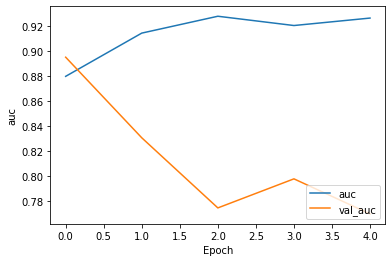

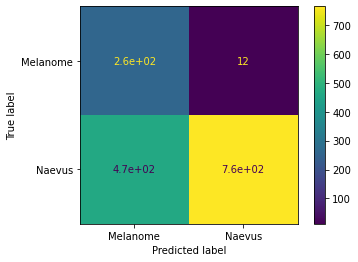

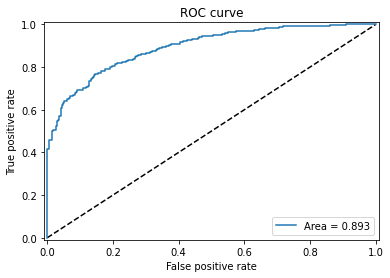

In [ ]:
plot_hist(hist, metrics='auc')
visu_results(np.asarray(y_test), np.asarray(predictions), confidence=np.asarray(predictions))

## 20 epochs

In [ ]:
epochs = 20
batch_size = 32
class_weight = {0:4.59, 1:1}

hist = hybrid.fit(traingen, validation_data=valgen, epochs=epochs, class_weight=class_weight, batch_size=batch_size)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
153/153 [==============================] - 227s 1s/step - loss: 0.9137 - auc: 0.8737 - val_loss: 0.6470 - val_auc: 0.7584
Epoch 2/20
153/153 [==============================] - 190s 1s/step - loss: 0.5665 - auc: 0.9250 - val_loss: 0.5185 - val_auc: 0.8432
Epoch 3/20
153/153 [==============================] - 190s 1s/step - loss: 0.6079 - auc: 0.9043 - val_loss: 0.4841 - val_auc: 0.8399
Epoch 4/20
153/153 [==============================] - 190s 1s/step - loss: 0.5584 - auc: 0.9275 - val_loss: 0.4801 - val_auc: 0.8535
Epoch 5/20
153/153 [==============================] - 189s 1s/step - loss: 0.5307 - auc: 0.9305 - val_loss: 0.5110 - val_auc: 0.8467
Epoch 6/20
153/153 [==============================] - 189s 1s/step - loss: 0.5634 - auc: 0.9137 - val_loss: 0.4083 - val_auc: 0.8849
Epoch 7/20
153/153 [==============================] - 189s 1s/st

In [ ]:
def CNN_predict(model, dataset):
  y_true = []
  y_pred = []
  for X, y in dataset:
    y_true += y.tolist()
    y_pred += model(X).numpy().tolist()
  return y_true, y_pred

y_test, predictions = CNN_predict(hybrid, testgen)

              precision    recall  f1-score   support

    Mélanome       0.43      0.91      0.59       273
      Naevus       0.97      0.74      0.84      1231

    accuracy                           0.77      1504
   macro avg       0.70      0.82      0.71      1504
weighted avg       0.88      0.77      0.79      1504

ROC score on test set :  0.9207127830198505


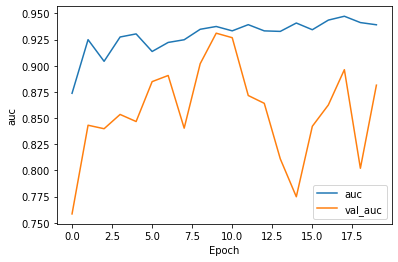

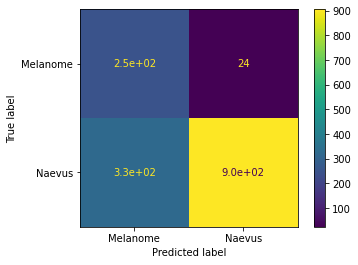

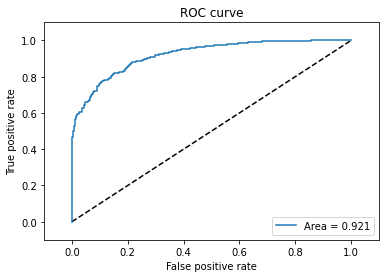

In [ ]:
plot_hist(hist, metrics='auc')
visu_results(np.asarray(y_test), np.asarray(predictions), confidence=np.asarray(predictions))

In [ ]:
b2 = get_efficientnet('b7')
b2.summary()

258080768/258076736 [==============================] - 2s 0us/step
Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
img_augmentation (Sequential)   (None, 600, 600, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 600, 600, 3)  0           img_augmentation[0][0]           
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, 600, 600, 3)  7           rescaling_3[0][0]                
____________________

## En retirant plus de couches

In [ ]:
def get_hybrid_model(cnn, hcnn):
  cnn._layers.pop()
  cnn._layers.pop()
  hcnn._layers.pop()
  hcnn._layers.pop()
  cnn.trainable = False
  hcnn.trainable = False

  combinedInput = concatenate([cnn.output, hcnn.output])

  combinedInput = Dropout(0.1)(combinedInput)
  x = Dense(32, activation="relu")(combinedInput)
  x = Dropout(0.1)(x)
  x = Dense(16, activation="relu")(x)
  x = Dropout(0.1)(x)
  outputs = layers.Dense(2, activation="softmax", name="predFinal")(x)

  # Compile
  model = tf.keras.Model(inputs=[cnn.inputs, hcnn.inputs], outputs=outputs, name="HybridFusion")
  model.compile(
    optimizer='adam', loss="binary_crossentropy", metrics='AUC'
  )
  return model

hcann = get_HCANN()
hcann.load_weights('/content/drive/MyDrive/Stage_LIS/Weights/hcann.h5')

b2 = get_efficientnet('b2')
b2.load_weights(weights_path+'b2.h5')

hybrid = get_hybrid_model(b2, hcann)

In [ ]:
epochs = 5
batch_size = 32
class_weight = {0:4.59, 1:1}

hist = hybrid.fit(traingen, validation_data=valgen, epochs=epochs, class_weight=class_weight, batch_size=batch_size)

Epoch 1/5
153/153 [==============================] - 227s 1s/step - loss: 1.2811 - auc: 0.3038 - val_loss: 0.7159 - val_auc: 0.3547
Epoch 2/5
153/153 [==============================] - 185s 1s/step - loss: 1.1337 - auc: 0.6498 - val_loss: 0.6734 - val_auc: 0.6495
Epoch 3/5
153/153 [==============================] - 186s 1s/step - loss: 0.8884 - auc: 0.7567 - val_loss: 0.6597 - val_auc: 0.7569
Epoch 4/5
153/153 [==============================] - 188s 1s/step - loss: 0.6817 - auc: 0.8545 - val_loss: 0.8755 - val_auc: 0.6233
Epoch 5/5
153/153 [==============================] - 186s 1s/step - loss: 0.8152 - auc: 0.8099 - val_loss: 0.5812 - val_auc: 0.8225


In [ ]:
y_test, predictions = CNN_predict(hybrid, testgen)

              precision    recall  f1-score   support

    Mélanome       0.35      0.90      0.51       273
      Naevus       0.97      0.64      0.77      1231

    accuracy                           0.68      1504
   macro avg       0.66      0.77      0.64      1504
weighted avg       0.86      0.68      0.72      1504

ROC score on test set :  0.8740890844871348


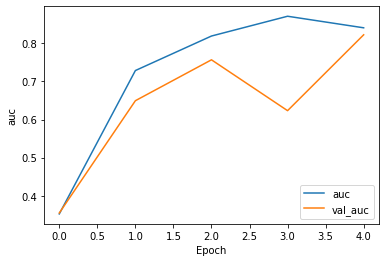

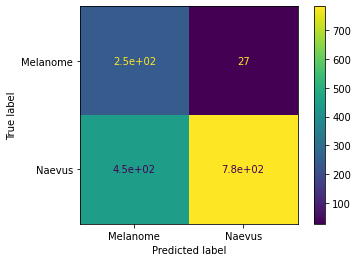

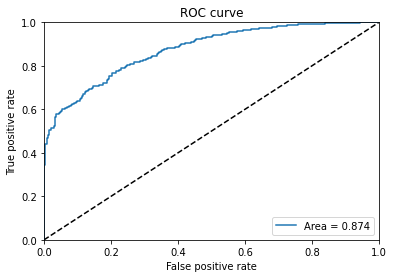

In [ ]:
plot_hist(hist, metrics='auc')
visu_results(np.asarray(y_test), np.asarray(predictions), confidence=np.asarray(predictions))

# Cross val

In [ ]:
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, df, features,
                 batch_size, val_split=0.,
                 shuffle=True, is_val=False):
        if val_split > 0:
            if is_val == False:
                self.df = df.copy()[:-int(len(df)*0.2)]
            else:
                self.df = df.copy()[int(len(df)*0.2):]
        else:
            self.df = df.copy()
        self.features = features
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n = len(self.df)
        self.num_classes = 2

    def on_epoch_end(self):
        if self.shuffle:
            self.df.sample(frac=1).reset_index(drop=True)

    def __get_input(self, path):
        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = tf.keras.preprocessing.image.smart_resize(image_arr, img_size)
        return image_arr

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batches = self.df[start:end]
        names = batches['Name']
        images = [self.__get_input(img) for img in names]
        hc_features = [self.features[i] for i in batches['Loc']]
        y = tf.keras.utils.to_categorical(batches['Label'], num_classes=2)
        images = np.asarray(images)
        hc_features = np.asarray(hc_features)
        #return [tf.Tensor(images, shape=(n)), tf.Tensor(hc_features)], y
        return [images, hc_features], y
        #return images, y
    
    def __len__(self):
        return self.n // self.batch_size

In [ ]:
from sklearn.model_selection import KFold
import pandas as pd

kf = KFold(n_splits=5)

train_df = pd.read_csv('/content/drive/MyDrive/Stage_LIS/train_files.csv')
scores = []

model = get_efficientnet('b2')

for train_index, test_index in kf.split(train_df['Name']):
    print("TRAIN:", train_index, "TEST:", test_index)

    traingen = CustomDataGen(train_df.iloc[train_index], train_features[train_index], val_split=0.2,
                         batch_size=32)

    valgen = CustomDataGen(train_df.iloc[train_index], train_features[train_index], val_split=0.2, is_val=True,
                         batch_size=32)
    
    testgen = CustomDataGen(train_df.iloc[test_index], test_features,
                         batch_size=32)
    
    model.fit(traingen, validation_data=valgen)
    scores.append(model.evaluate(testgen))

print(np.mean(scores[0]))

TRAIN: [1225 1226 1227 ... 6121 6122 6123] TEST: [   0    1    2 ... 1222 1223 1224]


NameError: ignored

In [ ]:
from sklearn.model_selection import KFold
import pandas as pd

class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, df,
                 batch_size, val_split=0.,
                 shuffle=True, is_val=False):
        if val_split > 0:
            if is_val == False:
                self.df = df.copy()[:-int(len(df)*0.2)]
            else:
                self.df = df.copy()[int(len(df)*0.2):]
        else:
            self.df = df.copy()
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n = len(self.df)
        self.num_classes = 2
        if self.shuffle:
            self.df.sample(frac=1).reset_index(drop=True)

    def on_epoch_end(self):
        if self.shuffle:
            self.df.sample(frac=1).reset_index(drop=True)

    def __get_input(self, path):
        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = tf.keras.preprocessing.image.smart_resize(image_arr, img_size)
        return image_arr

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batches = self.df[start:end]
        names = batches['Name']
        images = [self.__get_input(img) for img in names]
        y = tf.keras.utils.to_categorical(batches['Label'], num_classes=2)
        images = np.asarray(images)
        return images, y
    
    def __len__(self):
        return self.n // self.batch_size

kf = KFold(n_splits=5)

train_df = pd.read_csv('/content/drive/MyDrive/Stage_LIS/train_files.csv')
train_df = train_df.sample(frac=1).reset_index(drop=True)
scores = []

model = get_efficientnet('b2')

for train_index, test_index in kf.split(train_df['Name']):
    print("TRAIN:", train_index, "TEST:", test_index)

    traingen = CustomDataGen(train_df.iloc[train_index], val_split=0.2,
                         batch_size=32)

    valgen = CustomDataGen(train_df.iloc[train_index], val_split=0.2, is_val=True,
                         batch_size=32)
    
    testgen = CustomDataGen(train_df.iloc[test_index],
                         batch_size=32)
    
    model.fit(traingen, validation_data=valgen)
    scores.append(model.evaluate(testgen))

print(np.mean(scores[0]))

TRAIN: [1225 1226 1227 ... 6121 6122 6123] TEST: [   0    1    2 ... 1222 1223 1224]
38/38 [==============================] - 23s 614ms/step - loss: 0.4049 - auc: 0.9184
TRAIN: [   0    1    2 ... 6121 6122 6123] TEST: [1225 1226 1227 ... 2447 2448 2449]
38/38 [==============================] - 23s 608ms/step - loss: 0.3281 - auc: 0.9388
TRAIN: [   0    1    2 ... 6121 6122 6123] TEST: [2450 2451 2452 ... 3672 3673 3674]
38/38 [==============================] - 24s 619ms/step - loss: 0.2979 - auc: 0.9458
TRAIN: [   0    1    2 ... 6121 6122 6123] TEST: [3675 3676 3677 ... 4897 4898 4899]
38/38 [==============================] - 23s 611ms/step - loss: 0.2566 - auc: 0.9606
TRAIN: [   0    1    2 ... 4897 4898 4899] TEST: [4900 4901 4902 ... 6121 6122 6123]
38/38 [==============================] - 23s 611ms/step - loss: 0.3256 - auc: 0.9358
0.6616899818181992


In [ ]:
print(np.mean(scores, axis=0))

[0.32264776 0.93986601]


In [ ]:
print(scores)

[[3.4619240760803223, 0.10526316612958908], [0.2446436583995819, 1.0], [0.25685784220695496, 1.0], [0.26778754591941833, 0.9999979734420776], [0.39641764760017395, 0.9986879229545593]]


In [ ]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

for train_index, test_index in kf.split(train_df['Name']):
    print("TRAIN:", train_index, "TEST:", test_index)

    traingen = CustomDataGen(train_df.iloc[train_index], val_split=0.2,
                         batch_size=32)

    valgen = CustomDataGen(train_df.iloc[train_index], val_split=0.2, is_val=True,
                         batch_size=32)
    
    testgen = CustomDataGen(train_df.iloc[test_index],
                         batch_size=32)
    
    print(len([i for i in testgen.df['Label'] == 1.0 if i == True]))
    break

TRAIN: [1225 1226 1227 ... 6121 6122 6123] TEST: [   0    1    2 ... 1222 1223 1224]
986


In [ ]:
visu_results()

# Score par modèle + ensemble method

## CNNs

In [ ]:
models[0].summary()
models[-1].summary()

In [ ]:
models = []
weights_path = '/content/drive/MyDrive/Stage_LIS/Weights/'
fined_names = ('b0', 'b1', 'b2', 'b3', 'b4')
for name in fined_names:
  models.append(get_efficientnet(name))
  models[-1].load_weights(weights_path+name+'_fine.h5')
basic_names = ('b5', 'b6', 'b7')
for name in basic_names:
  models.append(get_efficientnet(name))
  models[-1].load_weights(weights_path+name+'.h5')

258080768/258076736 [==============================] - 3s 0us/step


In [ ]:
def predict(models, dataset):
  predictions = []
  y_true = []
  first = True
  for X, y in dataset:
    y_true += y.numpy().tolist()
    for i, model in enumerate(models):
      if first:
        predictions.append(model(X).numpy().tolist())
      else:
        predictions[i] += model(X).numpy().tolist()
    first = False
  return predictions, y_true

In [ ]:
predictions, y_true = predict(models, test_ds)

b0
              precision    recall  f1-score   support

    Mélanome       0.45      0.80      0.57       273
      Naevus       0.95      0.79      0.86      1260

    accuracy                           0.79      1533
   macro avg       0.70      0.79      0.72      1533
weighted avg       0.86      0.79      0.81      1533

ROC score on test set :  0.8879513343799057


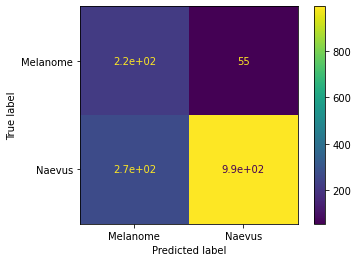

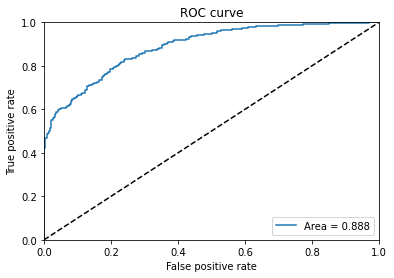

b1
              precision    recall  f1-score   support

    Mélanome       0.41      0.86      0.56       273
      Naevus       0.96      0.73      0.83      1260

    accuracy                           0.76      1533
   macro avg       0.69      0.80      0.69      1533
weighted avg       0.86      0.76      0.78      1533

ROC score on test set :  0.8947162625734054


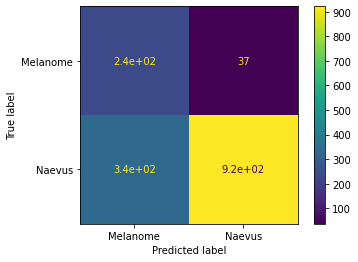

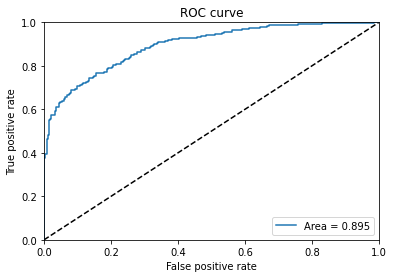

b2
              precision    recall  f1-score   support

    Mélanome       0.47      0.85      0.60       273
      Naevus       0.96      0.79      0.87      1260

    accuracy                           0.80      1533
   macro avg       0.71      0.82      0.74      1533
weighted avg       0.87      0.80      0.82      1533

ROC score on test set :  0.9097018722018722


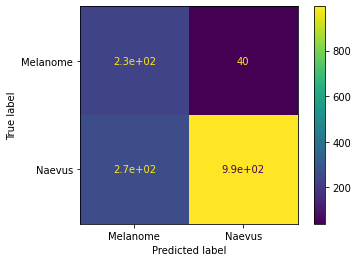

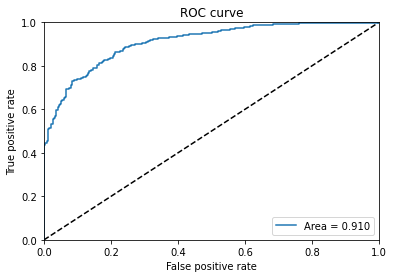

b3
              precision    recall  f1-score   support

    Mélanome       0.51      0.76      0.61       273
      Naevus       0.94      0.84      0.89      1260

    accuracy                           0.83      1533
   macro avg       0.73      0.80      0.75      1533
weighted avg       0.87      0.83      0.84      1533

ROC score on test set :  0.9004884004884005


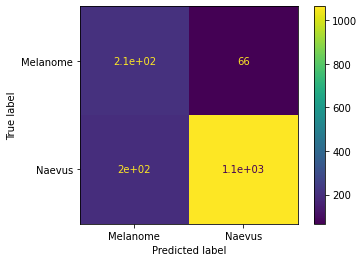

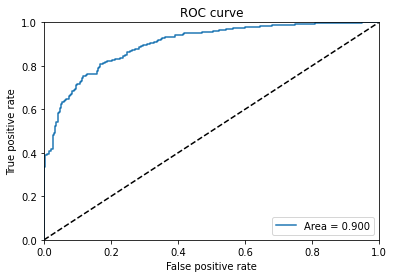

b4
              precision    recall  f1-score   support

    Mélanome       0.52      0.78      0.63       273
      Naevus       0.95      0.84      0.89      1260

    accuracy                           0.83      1533
   macro avg       0.73      0.81      0.76      1533
weighted avg       0.87      0.83      0.85      1533

ROC score on test set :  0.9090325018896448


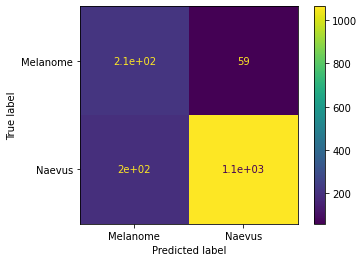

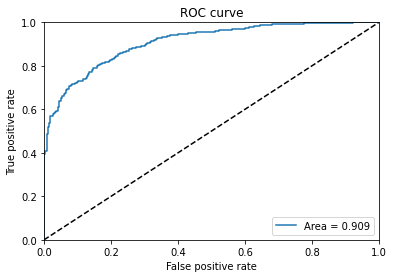

b5
              precision    recall  f1-score   support

    Mélanome       0.42      0.82      0.56       273
      Naevus       0.95      0.75      0.84      1260

    accuracy                           0.77      1533
   macro avg       0.69      0.79      0.70      1533
weighted avg       0.86      0.77      0.79      1533

ROC score on test set :  0.8769703180417465


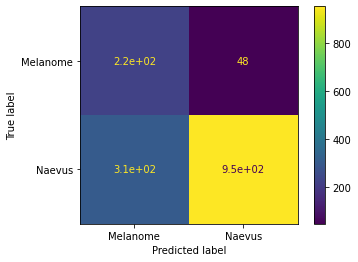

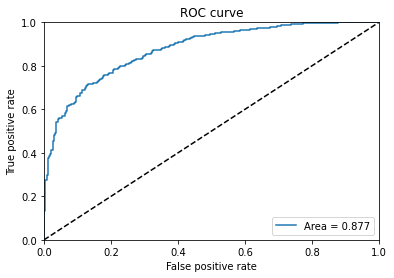

b6
              precision    recall  f1-score   support

    Mélanome       0.44      0.79      0.56       273
      Naevus       0.94      0.78      0.85      1260

    accuracy                           0.78      1533
   macro avg       0.69      0.78      0.71      1533
weighted avg       0.85      0.78      0.80      1533

ROC score on test set :  0.872158991801849


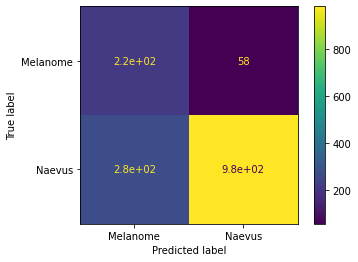

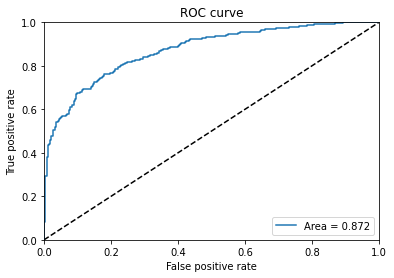

b7
              precision    recall  f1-score   support

    Mélanome       0.42      0.80      0.55       273
      Naevus       0.95      0.76      0.84      1260

    accuracy                           0.77      1533
   macro avg       0.68      0.78      0.70      1533
weighted avg       0.85      0.77      0.79      1533

ROC score on test set :  0.8695883481597768


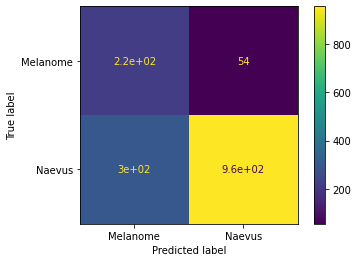

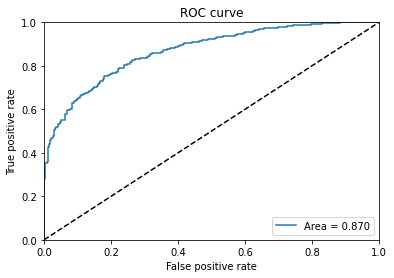

In [ ]:
for i, prediction in enumerate(predictions):
  print(names[i])
  visu_results(np.asarray(y_true), np.asarray(prediction), confidence=np.asarray(prediction))

In [ ]:
def late_fusion(predictions, weights=None):
  if weights != None:
    return np.mean([predictions[i] * weights[i] for i in range(len(predictions))], axis=0)
  else:
    return np.mean([predictions[i] for i in range(len(predictions))], axis=0)

              precision    recall  f1-score   support

    Mélanome       0.51      0.89      0.65       273
      Naevus       0.97      0.82      0.89      1260

    accuracy                           0.83      1533
   macro avg       0.74      0.85      0.77      1533
weighted avg       0.89      0.83      0.85      1533

ROC score on test set :  0.9383568812140239


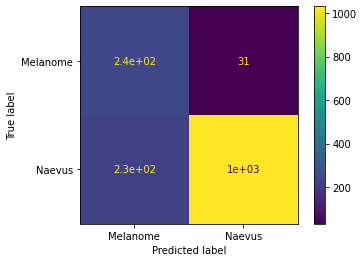

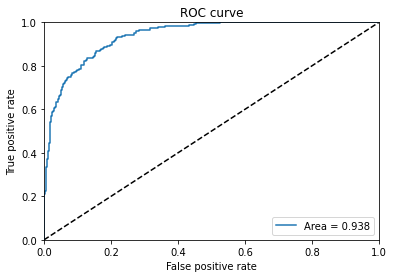

In [ ]:
final_pred = late_fusion(predictions)
visu_results(np.asarray(y_true), np.asarray(final_pred))

In [ ]:
def majority_vote(predictions):
  final_pred = []
  for instance in range(predictions.shape[1]):
    final_pred = [round(np.mean([np.argmax(predictions[model][instance])
      for model in range(predictions.shape[0])]))
      for instance in range(predictions.shape[1])]

  return final_pred

y_pred = majority_vote(np.asarray(predictions))

              precision    recall  f1-score   support

    Mélanome       0.48      0.92      0.63       273
      Naevus       0.98      0.79      0.87      1260

    accuracy                           0.81      1533
   macro avg       0.73      0.85      0.75      1533
weighted avg       0.89      0.81      0.83      1533

ROC score on test set :  0.8507326007326007


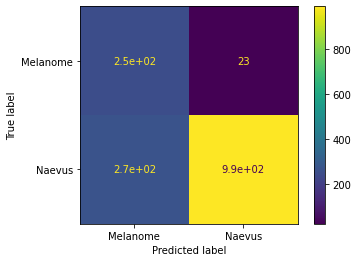

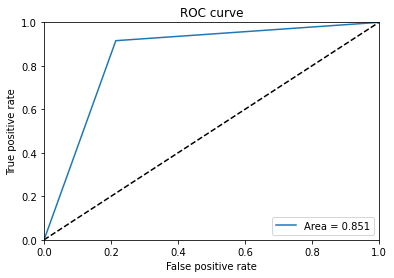

In [ ]:
final_pred = late_fusion(predictions)
visu_results(np.asarray(y_true), np.asarray(y_pred))

## Val ds

In [ ]:
predictions, y_true = predict(models, val_ds)

b0
              precision    recall  f1-score   support

    Mélanome       0.45      0.79      0.57       191
      Naevus       0.95      0.82      0.88      1033

    accuracy                           0.82      1224
   macro avg       0.70      0.80      0.73      1224
weighted avg       0.88      0.82      0.84      1224

ROC score on test set :  0.8901739963406536


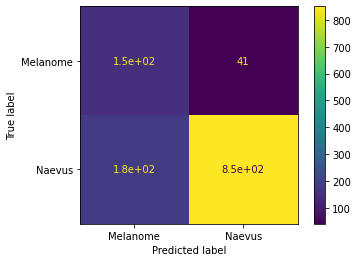

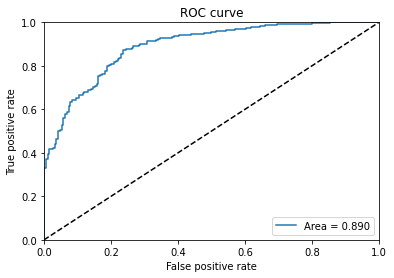

b1
              precision    recall  f1-score   support

    Mélanome       0.37      0.88      0.52       191
      Naevus       0.97      0.72      0.83      1033

    accuracy                           0.75      1224
   macro avg       0.67      0.80      0.68      1224
weighted avg       0.88      0.75      0.78      1224

ROC score on test set :  0.8945834579301886


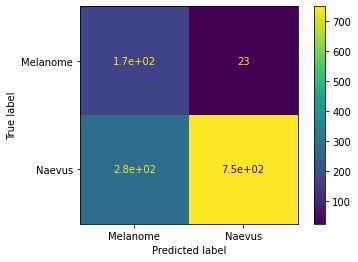

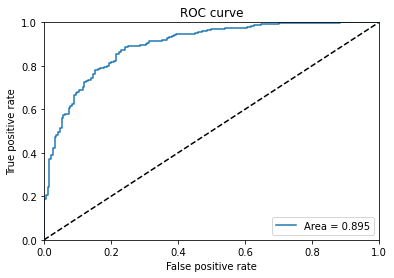

b2
              precision    recall  f1-score   support

    Mélanome       0.43      0.85      0.57       191
      Naevus       0.97      0.79      0.87      1033

    accuracy                           0.80      1224
   macro avg       0.70      0.82      0.72      1224
weighted avg       0.88      0.80      0.82      1224

ROC score on test set :  0.8968021266782563


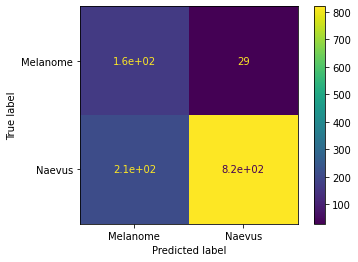

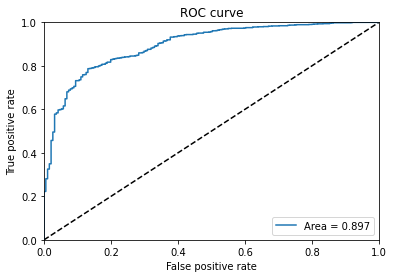

b3
              precision    recall  f1-score   support

    Mélanome       0.47      0.74      0.58       191
      Naevus       0.95      0.85      0.89      1033

    accuracy                           0.83      1224
   macro avg       0.71      0.80      0.74      1224
weighted avg       0.87      0.83      0.85      1224

ROC score on test set :  0.9014206575672948


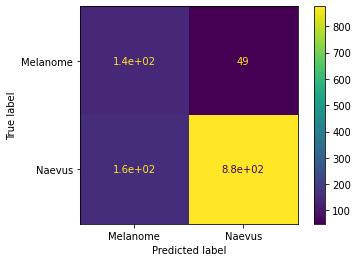

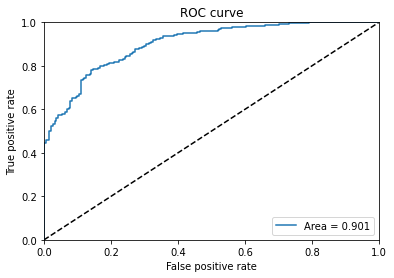

b4
              precision    recall  f1-score   support

    Mélanome       0.50      0.76      0.60       191
      Naevus       0.95      0.86      0.90      1033

    accuracy                           0.84      1224
   macro avg       0.72      0.81      0.75      1224
weighted avg       0.88      0.84      0.86      1224

ROC score on test set :  0.8971923893706635


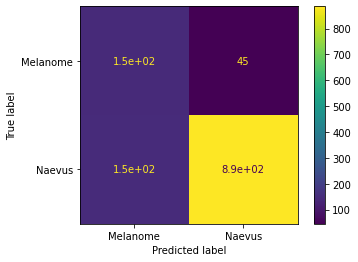

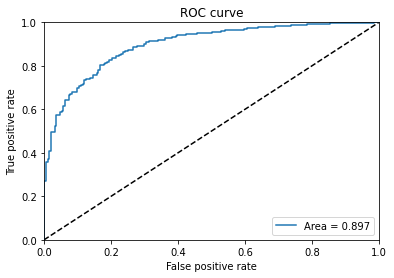

b5
              precision    recall  f1-score   support

    Mélanome       0.41      0.79      0.54       191
      Naevus       0.95      0.79      0.86      1033

    accuracy                           0.79      1224
   macro avg       0.68      0.79      0.70      1224
weighted avg       0.87      0.79      0.81      1224

ROC score on test set :  0.8872090135476906


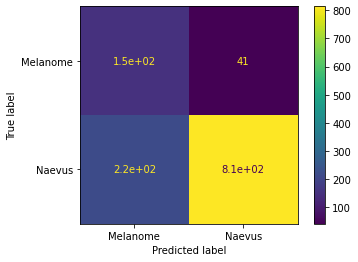

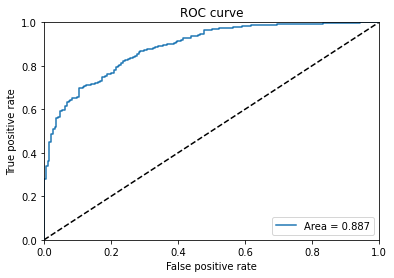

b6
              precision    recall  f1-score   support

    Mélanome       0.41      0.82      0.55       191
      Naevus       0.96      0.78      0.86      1033

    accuracy                           0.79      1224
   macro avg       0.68      0.80      0.70      1224
weighted avg       0.87      0.79      0.81      1224

ROC score on test set :  0.8858354916042838


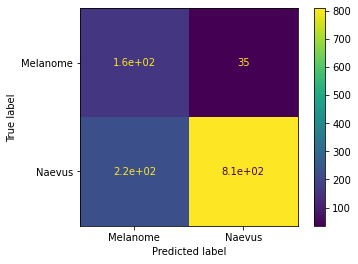

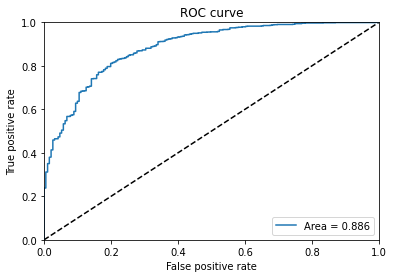

b7
              precision    recall  f1-score   support

    Mélanome       0.39      0.80      0.53       191
      Naevus       0.95      0.77      0.85      1033

    accuracy                           0.78      1224
   macro avg       0.67      0.79      0.69      1224
weighted avg       0.87      0.78      0.80      1224

ROC score on test set :  0.869032655357496


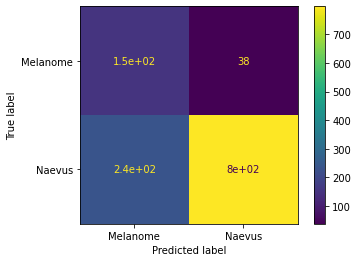

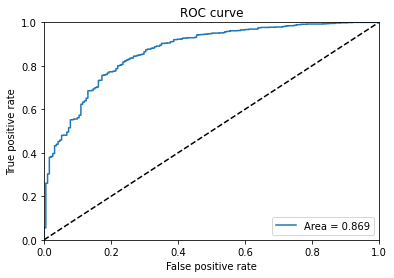

In [ ]:
for i, prediction in enumerate(predictions):
  print(names[i])
  visu_results(np.asarray(y_true), np.asarray(prediction), confidence=np.asarray(prediction))

              precision    recall  f1-score   support

    Mélanome       0.50      0.87      0.64       191
      Naevus       0.97      0.84      0.90      1033

    accuracy                           0.85      1224
   macro avg       0.74      0.86      0.77      1224
weighted avg       0.90      0.85      0.86      1224

ROC score on test set :  0.9347247634349198


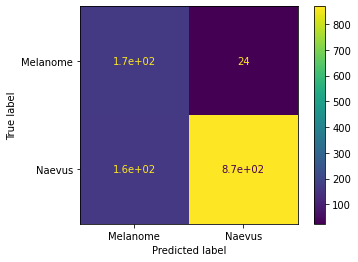

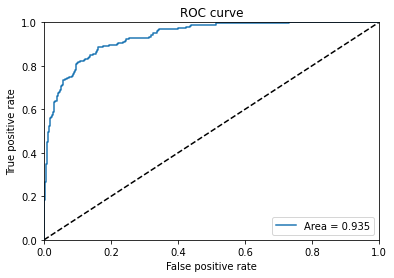

In [ ]:
final_pred = late_fusion(predictions)
visu_results(np.asarray(y_true), np.asarray(final_pred))

              precision    recall  f1-score   support

    Mélanome       0.47      0.90      0.61       191
      Naevus       0.98      0.81      0.89      1033

    accuracy                           0.82      1224
   macro avg       0.72      0.85      0.75      1224
weighted avg       0.90      0.82      0.84      1224

ROC score on test set :  0.8532586934815994


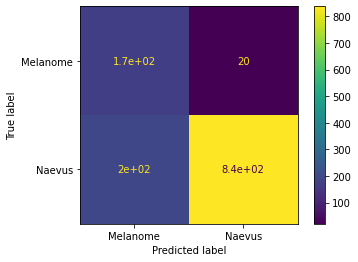

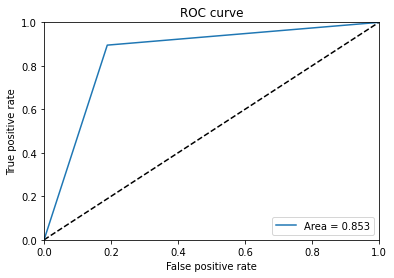

In [ ]:
y_pred = majority_vote(np.asarray(predictions))
final_pred = late_fusion(predictions)
visu_results(np.asarray(y_true), np.asarray(y_pred))

# All

In [ ]:
models = []
weights_path = '/content/drive/MyDrive/Stage_LIS/Weights/'
fined_names = ('b0', 'b1', 'b2', 'b3', 'b4')
for name in fined_names:
  models.append(get_efficientnet(name))
  models[-1].load_weights(weights_path+name+'_fine.h5')
basic_names = ('b5', 'b6', 'b7')
for name in basic_names:
  models.append(get_efficientnet(name))
  models[-1].load_weights(weights_path+name+'.h5')

models.append(get_HCANN())
models[-1].load_weights(weights_path+'hcann.h5')

258080768/258076736 [==============================] - 2s 0us/step


In [ ]:
def load_test_set_multimodal():
  base = '/content/ISIC_2019/'
  folder = 'TEST/'
  path = base+'NON_SEGMENTEES/'+folder
  X_testCNN = []
  for lesion_type in ('MEL', 'NEV'):
    current_path = path+lesion_type+'/'
    files = sorted([f for f in listdir(current_path) if isfile(join(current_path,f))])
    for file in files:
      img = cv2.resize(cv2.imread(current_path+file), img_size)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      X_testCNN.append(img)
  return np.asarray(X_testCNN)

def late_fusion(predictions, weights=None):
  return np.mean([predictions[i] * weights[i] for i in range(len(predictions))], axis=0)

In [ ]:
X_testCNN = load_test_set_multimodal()

In [ ]:
predictions = []
for model in models[:-1]:
  predictions.append(model.predict(X_testCNN))

predictions.append(models[-1].predict(X_testANN))

              precision    recall  f1-score   support

    Mélanome       0.58      0.65      0.61       273
      Naevus       0.92      0.90      0.91      1260

    accuracy                           0.85      1533
   macro avg       0.75      0.77      0.76      1533
weighted avg       0.86      0.85      0.86      1533

ROC score on test set :  0.8965281411709983


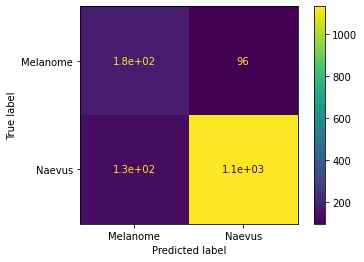

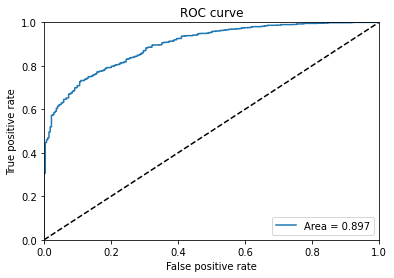

              precision    recall  f1-score   support

    Mélanome       0.49      0.81      0.61       273
      Naevus       0.95      0.81      0.88      1260

    accuracy                           0.81      1533
   macro avg       0.72      0.81      0.74      1533
weighted avg       0.87      0.81      0.83      1533

ROC score on test set :  0.905047531833246


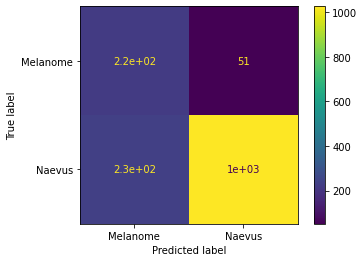

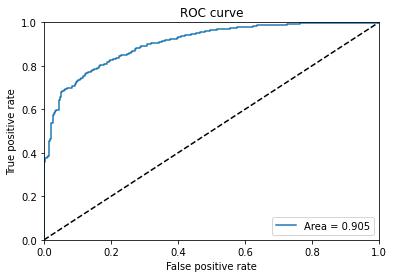

              precision    recall  f1-score   support

    Mélanome       0.52      0.81      0.63       273
      Naevus       0.95      0.84      0.89      1260

    accuracy                           0.83      1533
   macro avg       0.74      0.82      0.76      1533
weighted avg       0.88      0.83      0.85      1533

ROC score on test set :  0.9053346124774696


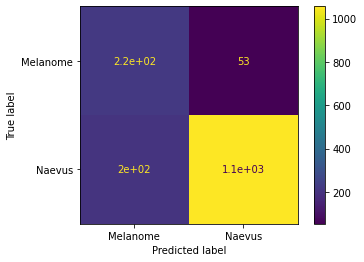

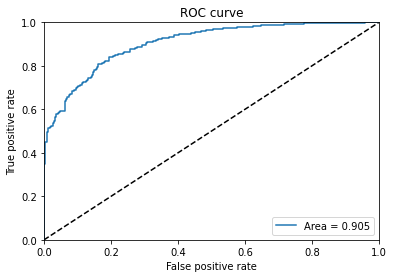

              precision    recall  f1-score   support

    Mélanome       0.54      0.77      0.63       273
      Naevus       0.94      0.86      0.90      1260

    accuracy                           0.84      1533
   macro avg       0.74      0.81      0.76      1533
weighted avg       0.87      0.84      0.85      1533

ROC score on test set :  0.907785336356765


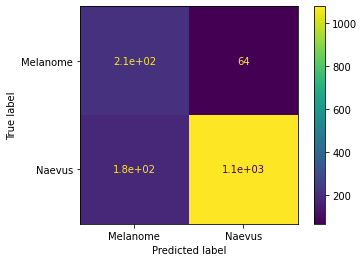

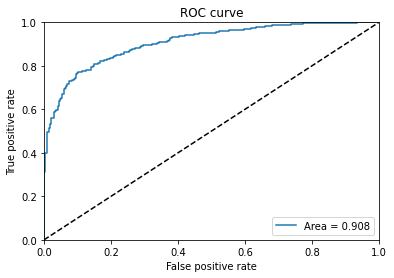

              precision    recall  f1-score   support

    Mélanome       0.48      0.85      0.61       273
      Naevus       0.96      0.80      0.87      1260

    accuracy                           0.81      1533
   macro avg       0.72      0.83      0.74      1533
weighted avg       0.88      0.81      0.83      1533

ROC score on test set :  0.9144972091400663


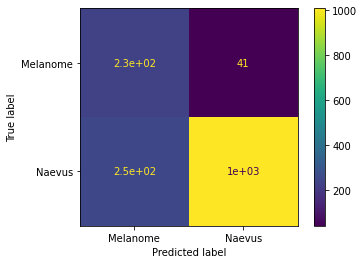

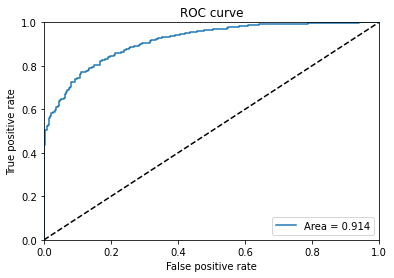

              precision    recall  f1-score   support

    Mélanome       0.44      0.88      0.59       273
      Naevus       0.97      0.76      0.85      1260

    accuracy                           0.78      1533
   macro avg       0.70      0.82      0.72      1533
weighted avg       0.87      0.78      0.80      1533

ROC score on test set :  0.9059603756032327


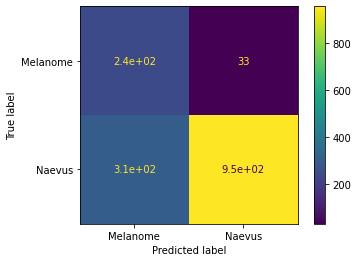

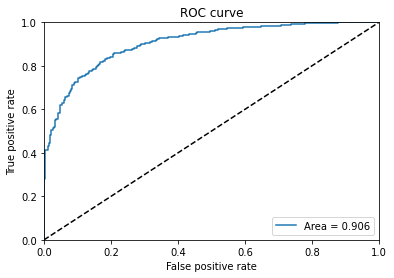

              precision    recall  f1-score   support

    Mélanome       0.38      0.93      0.54       273
      Naevus       0.98      0.67      0.80      1260

    accuracy                           0.72      1533
   macro avg       0.68      0.80      0.67      1533
weighted avg       0.87      0.72      0.75      1533

ROC score on test set :  0.8889891854177568


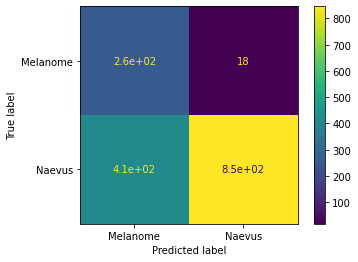

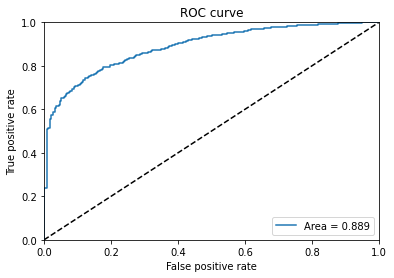

              precision    recall  f1-score   support

    Mélanome       0.36      0.94      0.52       273
      Naevus       0.98      0.64      0.78      1260

    accuracy                           0.70      1533
   macro avg       0.67      0.79      0.65      1533
weighted avg       0.87      0.70      0.73      1533

ROC score on test set :  0.8917022792022793


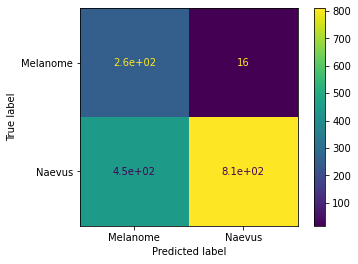

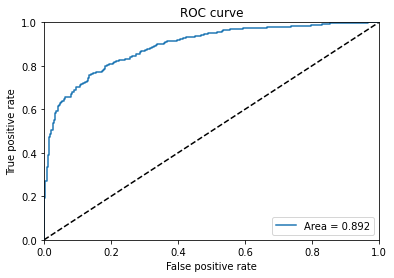

              precision    recall  f1-score   support

    Mélanome       0.37      0.91      0.52       273
      Naevus       0.97      0.66      0.79      1260

    accuracy                           0.70      1533
   macro avg       0.67      0.78      0.65      1533
weighted avg       0.86      0.70      0.74      1533

ROC score on test set :  0.8759986045700332


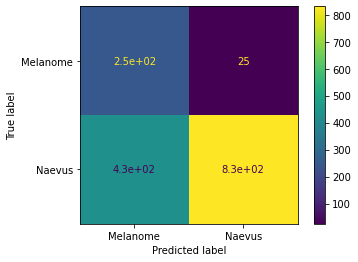

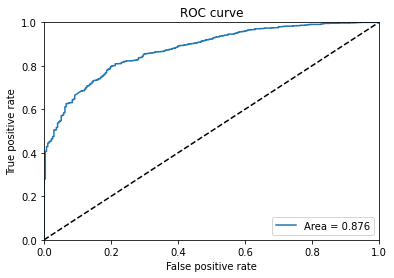

In [ ]:
for i, prediction in enumerate(predictions):
  visu_results(np.asarray(y_testANN), np.asarray(prediction), confidence=np.asarray(prediction))

In [ ]:
def late_fusion(predictions, weights=None):
  if weights != None:
    return np.mean([predictions[i] * weights[i] for i in range(len(predictions))], axis=0)
  else:
    return np.mean([predictions[i] for i in range(len(predictions))], axis=0)

              precision    recall  f1-score   support

    Mélanome       0.53      0.92      0.68       273
      Naevus       0.98      0.82      0.90      1260

    accuracy                           0.84      1533
   macro avg       0.76      0.87      0.79      1533
weighted avg       0.90      0.84      0.86      1533

ROC score on test set :  0.9415111343682772


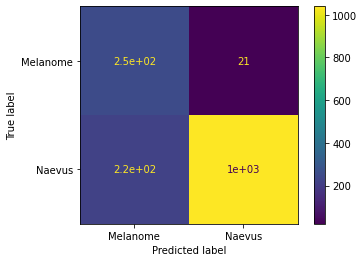

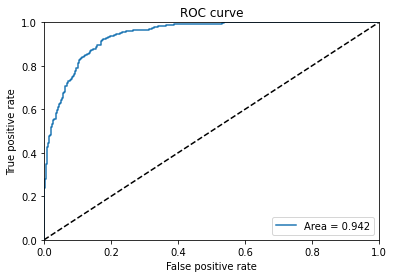

In [ ]:
final_pred = late_fusion(predictions)
visu_results(np.asarray(y_testANN), np.asarray(final_pred))

## Test juste avec CNN

In [ ]:
predictions = []
for model in models[:-1]:
  predictions.append(model.predict(X_testCNN))

              precision    recall  f1-score   support

    Mélanome       0.53      0.91      0.67       273
      Naevus       0.98      0.83      0.90      1260

    accuracy                           0.84      1533
   macro avg       0.76      0.87      0.78      1533
weighted avg       0.90      0.84      0.86      1533

ROC score on test set :  0.9392842607128321


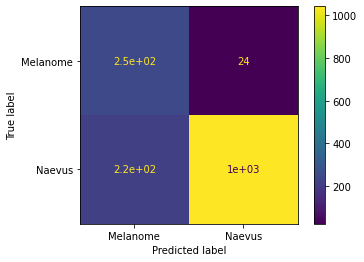

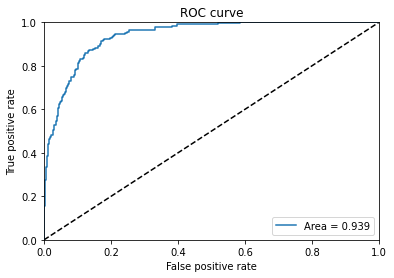

In [ ]:
final_pred = late_fusion(predictions)
visu_results(np.asarray(y_testANN), np.asarray(final_pred))

# Score par features ANN

In [ ]:
def get_features():
  ohe = OneHotEncoder()

  featuresNames = ['beta_quad_RGB', 'beta_quad_HSV', 'beta_quad_Lab', 'beta_quad_YCrCb',
                  'histos', 'histos_HSV', 'histos_Lab', 'histos_YCrCb',
                  'SPML_4_2', 'SPML_4_2_HSV', 'SPML_4_2_cielab', 'SPML_4_2_ycbcr',
                  'SPO', 'SP60_4', 'beta']

  loader = DataLoader(featuresNames)
  X_train, y_train, X_test, y_test = loader.load(centering=True)

  ohe.fit(y_train.reshape((-1, 1)))
  y_trainOH = ohe.transform(y_train.reshape((-1, 1))).toarray()
  y_testOH = ohe.transform(y_test.reshape((-1, 1))).toarray()
  return X_train, y_trainOH, X_test, y_testOH

def get_HCANN():
  model = Sequential()
  #model.add(Dense(32, activation='relu'))
  model.add(Dense(16, input_dim=729, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC'])
  return model

hcann = get_HCANN()
X_trainANN, y_trainANN, X_testANN, y_testANN = get_features()

Epoch 1/50
77/77 [==============================] - 1s 6ms/step - loss: 1.1010 - auc: 0.6746 - val_loss: 0.6720 - val_auc: 0.6404
Epoch 2/50
77/77 [==============================] - 0s 4ms/step - loss: 0.9726 - auc: 0.7813 - val_loss: 0.6230 - val_auc: 0.7376
Epoch 3/50
77/77 [==============================] - 0s 4ms/step - loss: 0.9050 - auc: 0.8072 - val_loss: 0.7382 - val_auc: 0.5622
Epoch 4/50
77/77 [==============================] - 0s 4ms/step - loss: 0.8941 - auc: 0.7904 - val_loss: 0.5407 - val_auc: 0.8173
Epoch 5/50
77/77 [==============================] - 0s 4ms/step - loss: 0.8437 - auc: 0.8273 - val_loss: 0.5403 - val_auc: 0.8119
Epoch 6/50
77/77 [==============================] - 0s 4ms/step - loss: 0.8448 - auc: 0.8217 - val_loss: 0.5140 - val_auc: 0.8325
Epoch 7/50
77/77 [==============================] - 0s 4ms/step - loss: 0.8133 - auc: 0.8348 - val_loss: 0.4786 - val_auc: 0.8606
Epoch 8/50
77/77 [==============================] - 0s 4ms/step - loss: 0.8252 - auc: 0.83

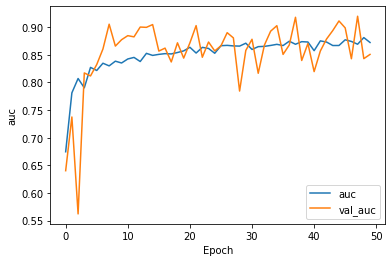

In [ ]:
hcann = get_HCANN()

epochs = 50
batch_size = 64
class_weight = {0:4.59, 1:1}
validation_split = 0.2

idx = np.random.permutation(len(X_trainANN))
X_trainANN2,y_trainANN2 = X_trainANN[idx], y_trainANN[idx]

history = hcann.fit(X_trainANN2, y_trainANN2, epochs=epochs, batch_size=batch_size, class_weight=class_weight, validation_split=validation_split, shuffle=True, workers=-1)
plot_hist(history, metrics='auc')

              precision    recall  f1-score   support

    Mélanome       0.40      0.87      0.54       273
      Naevus       0.96      0.71      0.82      1260

    accuracy                           0.74      1533
   macro avg       0.68      0.79      0.68      1533
weighted avg       0.86      0.74      0.77      1533

ROC score on test set :  0.8870399441828014


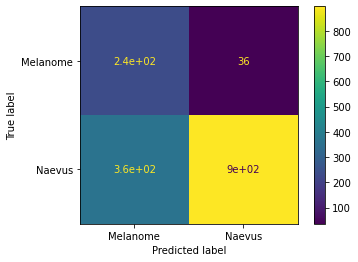

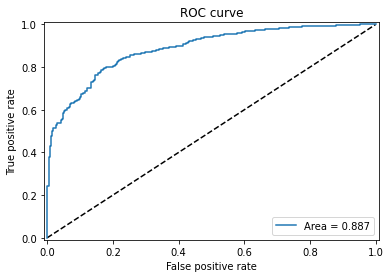

In [ ]:
y_predANN = hcann.predict(X_testANN)
visu_results(y_testANN, y_predANN, confidence=y_predANN)

In [ ]:
hcann.save_weights()

Epoch 1/50
77/77 [==============================] - 1s 6ms/step - loss: 1.1021 - auc: 0.6779 - val_loss: 0.6765 - val_auc: 0.7009
Epoch 2/50
77/77 [==============================] - 0s 3ms/step - loss: 1.0024 - auc: 0.7605 - val_loss: 0.5406 - val_auc: 0.8418
Epoch 3/50
77/77 [==============================] - 0s 3ms/step - loss: 0.9701 - auc: 0.7908 - val_loss: 0.7085 - val_auc: 0.6274
Epoch 4/50
77/77 [==============================] - 0s 4ms/step - loss: 0.9680 - auc: 0.7895 - val_loss: 0.6061 - val_auc: 0.7662
Epoch 5/50
77/77 [==============================] - 0s 4ms/step - loss: 0.9769 - auc: 0.7684 - val_loss: 0.6155 - val_auc: 0.7565
Epoch 6/50
77/77 [==============================] - 0s 3ms/step - loss: 0.9321 - auc: 0.7988 - val_loss: 0.4634 - val_auc: 0.8738
Epoch 7/50
77/77 [==============================] - 0s 3ms/step - loss: 0.9161 - auc: 0.8012 - val_loss: 0.4867 - val_auc: 0.8564
Epoch 8/50
77/77 [==============================] - 0s 4ms/step - loss: 0.9163 - auc: 0.79

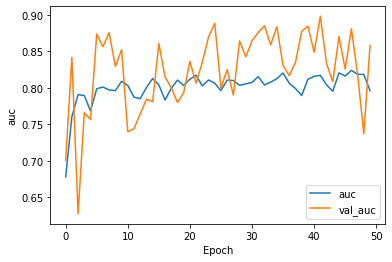

In [ ]:
def get_features():
  ohe = OneHotEncoder()

  featuresNames = ['SPML_4_2', 'SPML_4_2_HSV', 'SPML_4_2_cielab', 'SPML_4_2_ycbcr']

  loader = DataLoader(featuresNames)
  X_train, y_train, X_test, y_test = loader.load(centering=True)

  ohe.fit(y_train.reshape((-1, 1)))
  y_trainOH = ohe.transform(y_train.reshape((-1, 1))).toarray()
  y_testOH = ohe.transform(y_test.reshape((-1, 1))).toarray()
  return X_train, y_trainOH, X_test, y_testOH

def get_HCANN():
  model = Sequential()
  #model.add(Dense(32, activation='relu'))
  model.add(Dense(16, input_dim=48, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC'])
  return model

X_trainANN, y_trainANN, X_testANN, y_testANN = get_features()

hcann = get_HCANN()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
hcann.compile(loss=loss, optimizer=optimizer, metrics=['AUC'])

idx = np.random.permutation(len(X_trainANN))
X_trainANN2,y_trainANN2 = X_trainANN[idx], y_trainANN[idx]

history = hcann.fit(X_trainANN2, y_trainANN2, epochs=epochs, batch_size=batch_size,
                    class_weight=class_weight, validation_split=validation_split, shuffle=True, workers=-1)
plot_hist(history, metrics='auc')

              precision    recall  f1-score   support

    Mélanome       0.38      0.73      0.50       273
      Naevus       0.93      0.74      0.82      1260

    accuracy                           0.74      1533
   macro avg       0.65      0.73      0.66      1533
weighted avg       0.83      0.74      0.76      1533

ROC score on test set :  0.8080557009128437


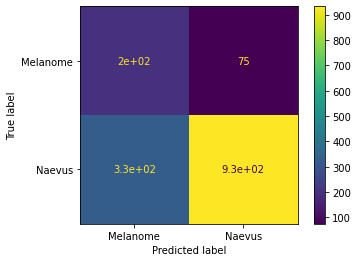

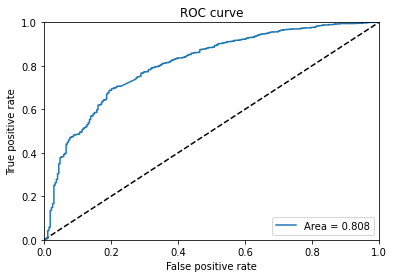

In [ ]:
y_predANN = hcann.predict(X_testANN)
visu_results(y_testANN, y_predANN, confidence=y_predANN)

Epoch 1/50
77/77 [==============================] - 1s 6ms/step - loss: 1.1139 - auc: 0.6565 - val_loss: 0.4521 - val_auc: 0.9275
Epoch 2/50
77/77 [==============================] - 0s 4ms/step - loss: 1.0265 - auc: 0.6800 - val_loss: 0.4603 - val_auc: 0.8903
Epoch 3/50
77/77 [==============================] - 0s 4ms/step - loss: 0.9836 - auc: 0.6980 - val_loss: 0.7307 - val_auc: 0.4989
Epoch 4/50
77/77 [==============================] - 0s 4ms/step - loss: 0.9637 - auc: 0.6881 - val_loss: 0.6449 - val_auc: 0.6818
Epoch 5/50
77/77 [==============================] - 0s 3ms/step - loss: 0.9422 - auc: 0.7129 - val_loss: 0.4163 - val_auc: 0.8907
Epoch 6/50
77/77 [==============================] - 0s 4ms/step - loss: 0.9261 - auc: 0.7231 - val_loss: 0.4873 - val_auc: 0.8336
Epoch 7/50
77/77 [==============================] - 0s 3ms/step - loss: 0.9226 - auc: 0.7089 - val_loss: 0.4481 - val_auc: 0.8613
Epoch 8/50
77/77 [==============================] - 0s 4ms/step - loss: 0.9339 - auc: 0.71

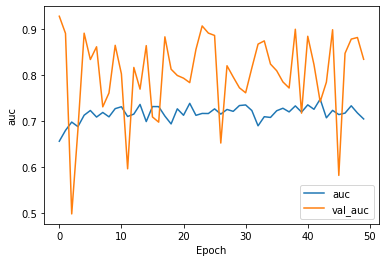

In [ ]:
def get_features():
  ohe = OneHotEncoder()

  featuresNames = ['histos', 'histos_HSV', 'histos_Lab', 'histos_YCrCb']

  loader = DataLoader(featuresNames)
  X_train, y_train, X_test, y_test = loader.load(centering=True)

  ohe.fit(y_train.reshape((-1, 1)))
  y_trainOH = ohe.transform(y_train.reshape((-1, 1))).toarray()
  y_testOH = ohe.transform(y_test.reshape((-1, 1))).toarray()
  return X_train, y_trainOH, X_test, y_testOH

def get_HCANN():
  model = Sequential()
  #model.add(Dense(32, activation='relu'))
  model.add(Dense(16, input_dim=360, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC'])
  return model

X_trainANN, y_trainANN, X_testANN, y_testANN = get_features()

hcann = get_HCANN()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
hcann.compile(loss=loss, optimizer=optimizer, metrics=['AUC'])

idx = np.random.permutation(len(X_trainANN))
X_trainANN2,y_trainANN2 = X_trainANN[idx], y_trainANN[idx]

history = hcann.fit(X_trainANN2, y_trainANN2, epochs=epochs, batch_size=batch_size, class_weight=class_weight, validation_split=validation_split, shuffle=True, workers=-1)
plot_hist(history, metrics='auc')

              precision    recall  f1-score   support

    Mélanome       0.36      0.87      0.51       273
      Naevus       0.96      0.66      0.78      1260

    accuracy                           0.70      1533
   macro avg       0.66      0.77      0.64      1533
weighted avg       0.85      0.70      0.73      1533

ROC score on test set :  0.8175242746671318


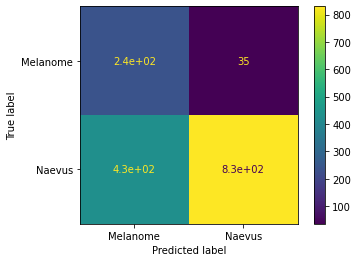

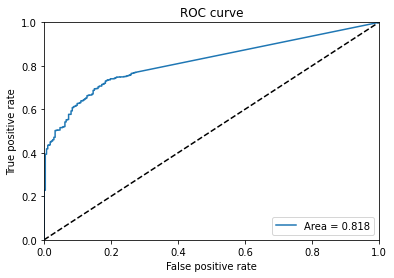

In [ ]:
y_predANN = hcann.predict(X_testANN)
visu_results(y_testANN, y_predANN, confidence=y_predANN)

Epoch 1/50
77/77 [==============================] - 1s 6ms/step - loss: 1.1109 - auc: 0.6948 - val_loss: 0.6315 - val_auc: 0.8048
Epoch 2/50
77/77 [==============================] - 0s 4ms/step - loss: 1.0051 - auc: 0.7573 - val_loss: 0.5351 - val_auc: 0.8477
Epoch 3/50
77/77 [==============================] - 0s 4ms/step - loss: 1.0130 - auc: 0.7100 - val_loss: 0.4753 - val_auc: 0.8878
Epoch 4/50
77/77 [==============================] - 0s 4ms/step - loss: 1.0092 - auc: 0.7414 - val_loss: 0.6102 - val_auc: 0.8198
Epoch 5/50
77/77 [==============================] - 0s 4ms/step - loss: 0.9713 - auc: 0.7760 - val_loss: 0.6753 - val_auc: 0.6534
Epoch 6/50
77/77 [==============================] - 0s 4ms/step - loss: 0.9662 - auc: 0.7667 - val_loss: 0.5191 - val_auc: 0.8562
Epoch 7/50
77/77 [==============================] - 0s 4ms/step - loss: 0.9677 - auc: 0.7816 - val_loss: 0.5223 - val_auc: 0.8467
Epoch 8/50
77/77 [==============================] - 0s 3ms/step - loss: 0.9410 - auc: 0.78

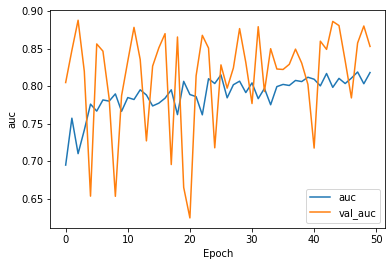

In [ ]:
def get_features():
  ohe = OneHotEncoder()

  featuresNames = ['beta_quad_RGB', 'beta_quad_HSV', 'beta_quad_Lab', 'beta_quad_YCrCb']

  loader = DataLoader(featuresNames)
  X_train, y_train, X_test, y_test = loader.load(centering=True)

  ohe.fit(y_train.reshape((-1, 1)))
  y_trainOH = ohe.transform(y_train.reshape((-1, 1))).toarray()
  y_testOH = ohe.transform(y_test.reshape((-1, 1))).toarray()
  return X_train, y_trainOH, X_test, y_testOH

def get_HCANN():
  model = Sequential()
  #model.add(Dense(32, activation='relu'))
  model.add(Dense(16, input_dim=144, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC'])
  return model


X_trainANN, y_trainANN, X_testANN, y_testANN = get_features()

hcann = get_HCANN()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
hcann.compile(loss=loss, optimizer=optimizer, metrics=['AUC'])

idx = np.random.permutation(len(X_trainANN))
X_trainANN2,y_trainANN2 = X_trainANN[idx], y_trainANN[idx]

history = hcann.fit(X_trainANN2, y_trainANN2, epochs=epochs, batch_size=batch_size, class_weight=class_weight, validation_split=validation_split, shuffle=True, workers=-1)
plot_hist(history, metrics='auc')

              precision    recall  f1-score   support

    Mélanome       0.39      0.61      0.48       273
      Naevus       0.90      0.80      0.85      1260

    accuracy                           0.76      1533
   macro avg       0.65      0.70      0.66      1533
weighted avg       0.81      0.76      0.78      1533

ROC score on test set :  0.8025800918658061


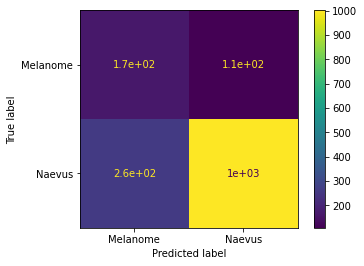

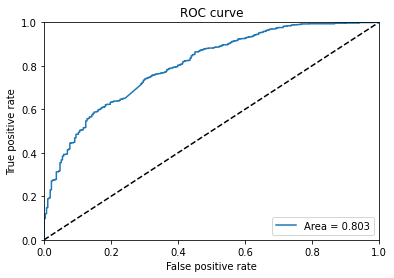

In [ ]:
y_predANN = hcann.predict(X_testANN)
visu_results(y_testANN, y_predANN, confidence=y_predANN)

Sans les espaces de couleurs

Epoch 1/50
77/77 [==============================] - 4s 7ms/step - loss: 1.1629 - auc: 0.6083 - val_loss: 0.6680 - val_auc: 0.7974
Epoch 2/50
77/77 [==============================] - 0s 4ms/step - loss: 1.0765 - auc: 0.7654 - val_loss: 0.7657 - val_auc: 0.3433
Epoch 3/50
77/77 [==============================] - 0s 3ms/step - loss: 1.0595 - auc: 0.7461 - val_loss: 0.5886 - val_auc: 0.8492
Epoch 4/50
77/77 [==============================] - 0s 3ms/step - loss: 1.0057 - auc: 0.7779 - val_loss: 0.5451 - val_auc: 0.8606
Epoch 5/50
77/77 [==============================] - 0s 4ms/step - loss: 0.9951 - auc: 0.7969 - val_loss: 0.5649 - val_auc: 0.8466
Epoch 6/50
77/77 [==============================] - 0s 4ms/step - loss: 0.9802 - auc: 0.7882 - val_loss: 0.6349 - val_auc: 0.7320
Epoch 7/50
77/77 [==============================] - 0s 3ms/step - loss: 0.9539 - auc: 0.7983 - val_loss: 0.5122 - val_auc: 0.8697
Epoch 8/50
77/77 [==============================] - 0s 4ms/step - loss: 0.9707 - auc: 0.79

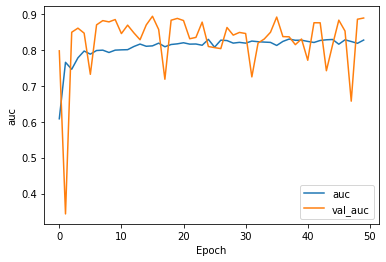

In [ ]:
def get_features():
  ohe = OneHotEncoder()

  featuresNames = ['beta_quad_RGB',
                  'histos',
                  'SPML_4_2',
                  'SPO', 'SP60_4']

  loader = DataLoader(featuresNames)
  X_train, y_train, X_test, y_test = loader.load(centering=True)

  ohe.fit(y_train.reshape((-1, 1)))
  y_trainOH = ohe.transform(y_train.reshape((-1, 1))).toarray()
  y_testOH = ohe.transform(y_test.reshape((-1, 1))).toarray()
  return X_train, y_trainOH, X_test, y_testOH

def get_HCANN():
  model = Sequential()
  #model.add(Dense(32, activation='relu'))
  model.add(Dense(16, input_dim=300, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC'])
  return model

X_trainANN, y_trainANN, X_testANN, y_testANN = get_features()

hcann = get_HCANN()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
hcann.compile(loss=loss, optimizer=optimizer, metrics=['AUC'])

idx = np.random.permutation(len(X_trainANN))
X_trainANN2,y_trainANN2 = X_trainANN[idx], y_trainANN[idx]

epochs = 50
batch_size = 64
class_weight = {0:4.59, 1:1}
validation_split = 0.2

history = hcann.fit(X_trainANN2, y_trainANN2, epochs=epochs, batch_size=batch_size,
                    class_weight=class_weight, validation_split=validation_split, shuffle=True, workers=-1)
plot_hist(history, metrics='auc')

              precision    recall  f1-score   support

    Mélanome       0.51      0.56      0.53       273
      Naevus       0.90      0.88      0.89      1260

    accuracy                           0.83      1533
   macro avg       0.71      0.72      0.71      1533
weighted avg       0.83      0.83      0.83      1533

ROC score on test set :  0.8478370835513693


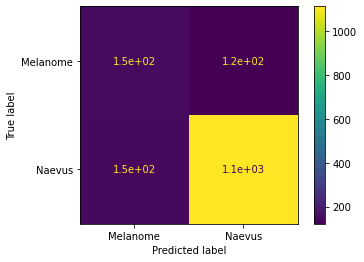

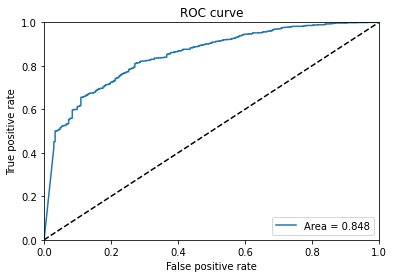

In [ ]:
y_predANN = hcann.predict(X_testANN)
visu_results(y_testANN, y_predANN, confidence=y_predANN)

Epoch 1/50
77/77 [==============================] - 1s 6ms/step - loss: 1.1363 - auc: 0.7074 - val_loss: 0.6370 - val_auc: 0.8373
Epoch 2/50
77/77 [==============================] - 0s 4ms/step - loss: 1.0640 - auc: 0.7609 - val_loss: 0.6136 - val_auc: 0.8419
Epoch 3/50
77/77 [==============================] - 0s 4ms/step - loss: 1.0469 - auc: 0.7573 - val_loss: 0.6100 - val_auc: 0.8078
Epoch 4/50
77/77 [==============================] - 0s 3ms/step - loss: 0.9897 - auc: 0.7646 - val_loss: 0.5169 - val_auc: 0.8886
Epoch 5/50
77/77 [==============================] - 0s 4ms/step - loss: 0.9792 - auc: 0.7951 - val_loss: 0.5377 - val_auc: 0.8601
Epoch 6/50
77/77 [==============================] - 0s 4ms/step - loss: 0.9464 - auc: 0.7958 - val_loss: 0.5395 - val_auc: 0.8483
Epoch 7/50
77/77 [==============================] - 0s 3ms/step - loss: 0.9627 - auc: 0.7983 - val_loss: 0.5785 - val_auc: 0.8189
Epoch 8/50
77/77 [==============================] - 0s 3ms/step - loss: 0.9369 - auc: 0.81

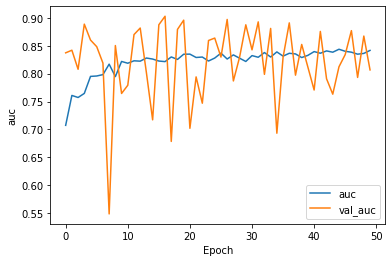

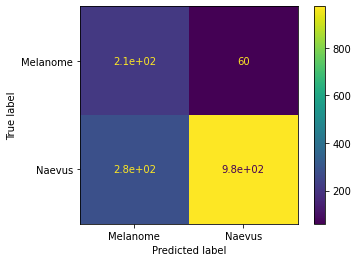

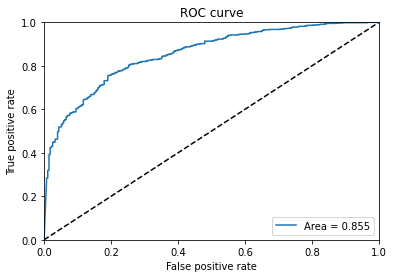

In [ ]:
def get_features():
  ohe = OneHotEncoder()

  featuresNames = ['beta_quad_HSV',
                  'histos_HSV',
                  'SPML_4_2_HSV',
                  'SPO', 'SP60_4']

  loader = DataLoader(featuresNames)
  X_train, y_train, X_test, y_test = loader.load(centering=True)

  ohe.fit(y_train.reshape((-1, 1)))
  y_trainOH = ohe.transform(y_train.reshape((-1, 1))).toarray()
  y_testOH = ohe.transform(y_test.reshape((-1, 1))).toarray()
  return X_train, y_trainOH, X_test, y_testOH

def get_HCANN():
  model = Sequential()
  #model.add(Dense(32, activation='relu'))
  model.add(Dense(16, input_dim=300, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC'])
  return model

X_trainANN, y_trainANN, X_testANN, y_testANN = get_features()

hcann = get_HCANN()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
hcann.compile(loss=loss, optimizer=optimizer, metrics=['AUC'])

idx = np.random.permutation(len(X_trainANN))
X_trainANN2,y_trainANN2 = X_trainANN[idx], y_trainANN[idx]

epochs = 50
batch_size = 64
class_weight = {0:4.59, 1:1}
validation_split = 0.2

history = hcann.fit(X_trainANN2, y_trainANN2, epochs=epochs, batch_size=batch_size,
                    class_weight=class_weight, validation_split=validation_split, shuffle=True, workers=-1)
plot_hist(history, metrics='auc')

y_predANN = hcann.predict(X_testANN)
visu_results(y_testANN, y_predANN, confidence=y_predANN)

Epoch 1/50
77/77 [==============================] - 1s 6ms/step - loss: 1.1561 - auc: 0.6063 - val_loss: 0.7509 - val_auc: 0.2634
Epoch 2/50
77/77 [==============================] - 0s 4ms/step - loss: 1.0644 - auc: 0.5879 - val_loss: 0.6047 - val_auc: 0.8462
Epoch 3/50
77/77 [==============================] - 0s 4ms/step - loss: 1.0053 - auc: 0.7635 - val_loss: 0.7040 - val_auc: 0.5640
Epoch 4/50
77/77 [==============================] - 0s 4ms/step - loss: 0.9805 - auc: 0.7899 - val_loss: 0.5316 - val_auc: 0.8672
Epoch 5/50
77/77 [==============================] - 0s 3ms/step - loss: 0.9670 - auc: 0.7965 - val_loss: 0.5908 - val_auc: 0.8014
Epoch 6/50
77/77 [==============================] - 0s 4ms/step - loss: 0.9990 - auc: 0.7907 - val_loss: 0.6276 - val_auc: 0.7526
Epoch 7/50
77/77 [==============================] - 0s 3ms/step - loss: 0.9796 - auc: 0.7930 - val_loss: 0.5401 - val_auc: 0.8644
Epoch 8/50
77/77 [==============================] - 0s 3ms/step - loss: 0.9832 - auc: 0.79

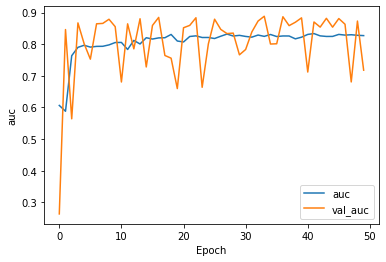

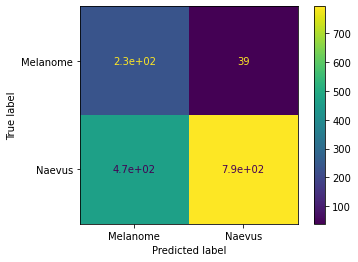

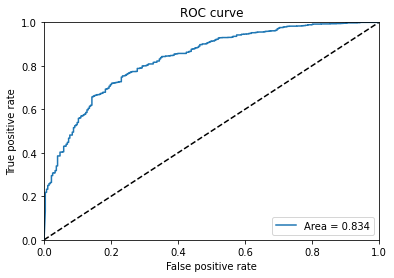

In [ ]:
def get_features():
  ohe = OneHotEncoder()

  featuresNames = ['beta_quad_Lab',
                  'histos_Lab',
                  'SPML_4_2_cielab',
                  'SPO', 'SP60_4']

  loader = DataLoader(featuresNames)
  X_train, y_train, X_test, y_test = loader.load(centering=True)

  ohe.fit(y_train.reshape((-1, 1)))
  y_trainOH = ohe.transform(y_train.reshape((-1, 1))).toarray()
  y_testOH = ohe.transform(y_test.reshape((-1, 1))).toarray()
  return X_train, y_trainOH, X_test, y_testOH

def get_HCANN():
  model = Sequential()
  #model.add(Dense(32, activation='relu'))
  model.add(Dense(16, input_dim=300, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC'])
  return model

X_trainANN, y_trainANN, X_testANN, y_testANN = get_features()

hcann = get_HCANN()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
hcann.compile(loss=loss, optimizer=optimizer, metrics=['AUC'])

idx = np.random.permutation(len(X_trainANN))
X_trainANN2,y_trainANN2 = X_trainANN[idx], y_trainANN[idx]

epochs = 50
batch_size = 64
class_weight = {0:4.59, 1:1}
validation_split = 0.2

history = hcann.fit(X_trainANN2, y_trainANN2, epochs=epochs, batch_size=batch_size,
                    class_weight=class_weight, validation_split=validation_split, shuffle=True, workers=-1)
plot_hist(history, metrics='auc')

y_predANN = hcann.predict(X_testANN)
visu_results(y_testANN, y_predANN, confidence=y_predANN)

Epoch 1/50
77/77 [==============================] - 1s 6ms/step - loss: 1.1513 - auc: 0.5129 - val_loss: 0.6595 - val_auc: 0.7832
Epoch 2/50
77/77 [==============================] - 0s 4ms/step - loss: 1.0515 - auc: 0.7120 - val_loss: 0.5660 - val_auc: 0.8576
Epoch 3/50
77/77 [==============================] - 0s 3ms/step - loss: 1.0600 - auc: 0.7781 - val_loss: 0.6752 - val_auc: 0.6607
Epoch 4/50
77/77 [==============================] - 0s 3ms/step - loss: 0.9974 - auc: 0.7479 - val_loss: 0.5366 - val_auc: 0.8916
Epoch 5/50
77/77 [==============================] - 0s 3ms/step - loss: 0.9866 - auc: 0.7831 - val_loss: 0.5617 - val_auc: 0.8461
Epoch 6/50
77/77 [==============================] - 0s 3ms/step - loss: 0.9860 - auc: 0.7857 - val_loss: 0.8159 - val_auc: 0.4458
Epoch 7/50
77/77 [==============================] - 0s 4ms/step - loss: 1.0023 - auc: 0.7658 - val_loss: 0.5729 - val_auc: 0.8348
Epoch 8/50
77/77 [==============================] - 0s 4ms/step - loss: 0.9754 - auc: 0.78

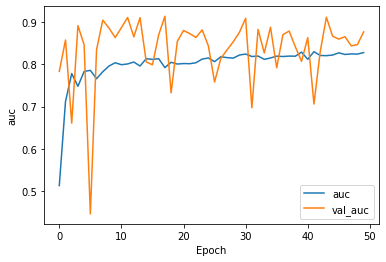

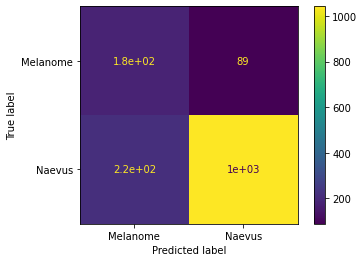

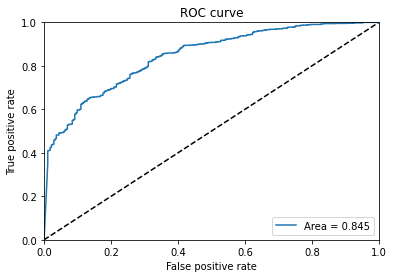

In [ ]:
def get_features():
  ohe = OneHotEncoder()

  featuresNames = ['beta_quad_YCrCb',
                  'histos_YCrCb',
                  'SPML_4_2_ycbcr',
                  'SPO', 'SP60_4']

  loader = DataLoader(featuresNames)
  X_train, y_train, X_test, y_test = loader.load(centering=True)

  ohe.fit(y_train.reshape((-1, 1)))
  y_trainOH = ohe.transform(y_train.reshape((-1, 1))).toarray()
  y_testOH = ohe.transform(y_test.reshape((-1, 1))).toarray()
  return X_train, y_trainOH, X_test, y_testOH

def get_HCANN():
  model = Sequential()
  #model.add(Dense(32, activation='relu'))
  model.add(Dense(16, input_dim=300, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC'])
  return model

X_trainANN, y_trainANN, X_testANN, y_testANN = get_features()

hcann = get_HCANN()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
hcann.compile(loss=loss, optimizer=optimizer, metrics=['AUC'])

idx = np.random.permutation(len(X_trainANN))
X_trainANN2,y_trainANN2 = X_trainANN[idx], y_trainANN[idx]

epochs = 50
batch_size = 64
class_weight = {0:4.59, 1:1}
validation_split = 0.2

history = hcann.fit(X_trainANN2, y_trainANN2, epochs=epochs, batch_size=batch_size,
                    class_weight=class_weight, validation_split=validation_split, shuffle=True, workers=-1)
plot_hist(history, metrics='auc')

y_predANN = hcann.predict(X_testANN)
visu_results(y_testANN, y_predANN, confidence=y_predANN)

              precision    recall  f1-score   support

    Mélanome       0.50      0.84      0.63       273
      Naevus       0.96      0.82      0.88      1260

    accuracy                           0.82      1533
   macro avg       0.73      0.83      0.75      1533
weighted avg       0.88      0.82      0.84      1533

ROC score on test set :  0.9210186638758067


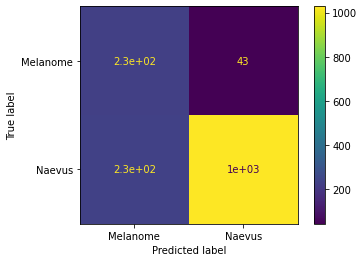

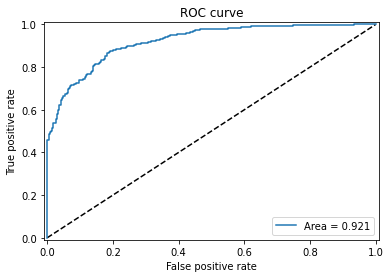

In [ ]:
weights = (1,1)
y_pred = late_fusion(predictions, weights=weights)
visu_results(y_testANN, y_pred, confidence=y_pred)

#Test

In [ ]:
b2.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
img_augmentation (Sequential)   (None, 260, 260, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 260, 260, 3)  0           img_augmentation[0][0]           
__________________________________________________________________________________________________
normalization (Normalization)   (None, 260, 260, 3)  7           rescaling[0][0]                  
_______________________________________________________________________________________

In [ ]:
hcann.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                11440     
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 11,474
Trainable params: 11,474
Non-trainable params: 0
_________________________________________________________________


# Cross Val ANN

In [ ]:
hcann = get_HCANN()
X_trainANN, y_trainANN, X_testANN, y_testANN = get_features()

In [ ]:
X = np.concatenate((X_trainANN, X_testANN), axis=0)
y = np.concatenate((y_trainANN, y_testANN), axis=0)

Fold 1 / 5
48/48 [==============================] - 0s 3ms/step - loss: 0.4395 - auc: 0.8651
              precision    recall  f1-score   support

    Mélanome       0.40      0.86      0.55       273
      Naevus       0.96      0.73      0.83      1259

    accuracy                           0.75      1532
   macro avg       0.68      0.79      0.69      1532
weighted avg       0.86      0.75      0.78      1532

ROC score on test set :  0.8610095226457419


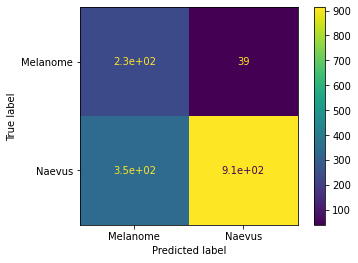

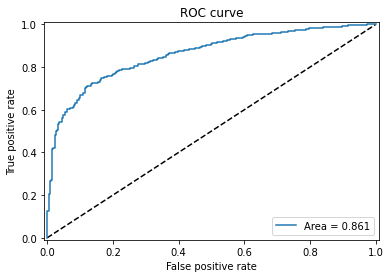

Fold 2 / 5
48/48 [==============================] - 0s 2ms/step - loss: 0.3400 - auc: 0.9278
              precision    recall  f1-score   support

    Mélanome       0.50      0.90      0.64       272
      Naevus       0.97      0.81      0.88      1260

    accuracy                           0.82      1532
   macro avg       0.74      0.85      0.76      1532
weighted avg       0.89      0.82      0.84      1532

ROC score on test set :  0.9194138071895425


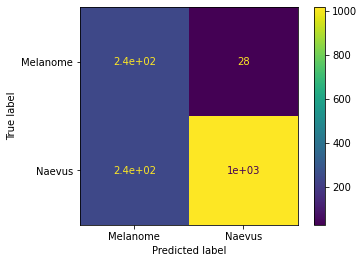

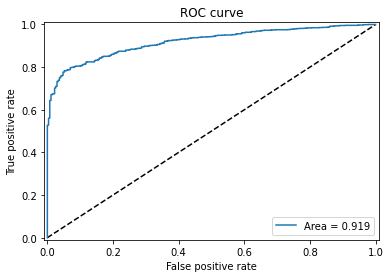

Fold 3 / 5
48/48 [==============================] - 0s 2ms/step - loss: 0.5472 - auc: 0.7964
              precision    recall  f1-score   support

    Mélanome       0.34      0.86      0.49       272
      Naevus       0.96      0.64      0.77      1259

    accuracy                           0.68      1531
   macro avg       0.65      0.75      0.63      1531
weighted avg       0.85      0.68      0.72      1531

ROC score on test set :  0.832427113021539


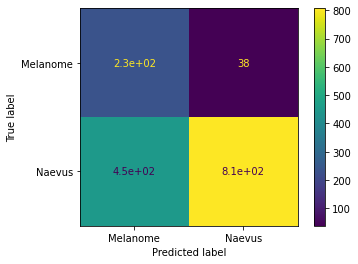

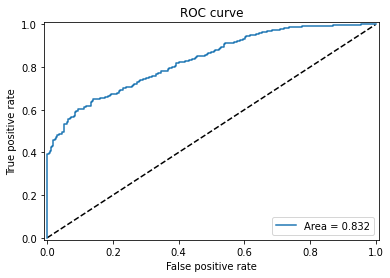

Fold 4 / 5
48/48 [==============================] - 0s 2ms/step - loss: 1.1638 - auc: 0.4483
              precision    recall  f1-score   support

    Mélanome       0.25      0.92      0.39       272
      Naevus       0.96      0.39      0.56      1259

    accuracy                           0.49      1531
   macro avg       0.60      0.66      0.48      1531
weighted avg       0.83      0.49      0.53      1531

ROC score on test set :  0.7996177521842733


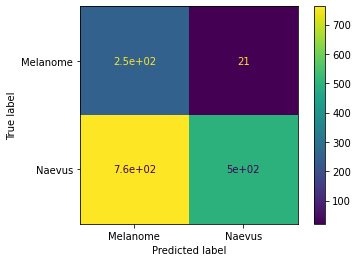

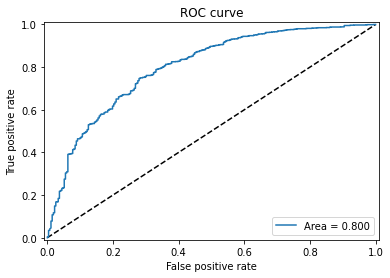

Fold 5 / 5
48/48 [==============================] - 0s 2ms/step - loss: 0.6055 - auc: 0.8181
              precision    recall  f1-score   support

    Mélanome       0.39      0.79      0.52       272
      Naevus       0.94      0.73      0.82      1259

    accuracy                           0.74      1531
   macro avg       0.67      0.76      0.67      1531
weighted avg       0.84      0.74      0.77      1531

ROC score on test set :  0.8499830631219922


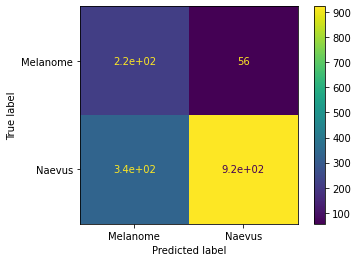

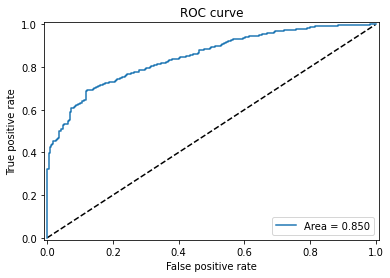

Loss and AUC: [0.61921591 0.77113256]
Confusion matrix: [[235.8  36.4]
 [427.8 831.4]]


In [ ]:
from sklearn.model_selection import StratifiedKFold

n_splits = 5
class_weight={0:4,1:1}

epochs = 50
batch_size = 64
validation_split = 0.2

kf = StratifiedKFold(n_splits=n_splits)

score_by_model = []
confusions_by_model = []
scores = []
confusions = []
nb_iter=0
for train_index, test_index in kf.split(X, np.argmax(y, axis=1)):
    print('Fold', nb_iter + 1, "/", n_splits)
    nb_iter += 1

    hcann = get_HCANN()

    history = hcann.fit(X[train_index], y[train_index], epochs=epochs, batch_size=batch_size,
                        class_weight=class_weight, validation_split=validation_split,
                        shuffle=True, workers=-1, verbose=0)

    scores.append(hcann.evaluate(X[test_index], y[test_index]))

    '''
    predictions = []
    y_test = []
    for X, y in testgen:
        predictions += list(model.predict(X))
        y_test += list(y)
    '''

    predictions = hcann.predict(X[test_index])

    confusions.append(confusion_matrix(np.argmax(y[test_index], axis=1), np.argmax(predictions, axis=1), normalize=None))
    visu_results(np.asarray(y[test_index]), np.asarray(predictions), confidence=np.asarray(predictions))

score_by_model.append(np.mean(scores, axis=0))
confusions_by_model.append(np.mean(confusions, axis=0))

print('Loss and AUC:', score_by_model[-1])
print('Confusion matrix:', confusions_by_model[-1])

# CNN learns to predict handcrafted features

In [ ]:
def get_features():
  ohe = OneHotEncoder()

  featuresNames = ['beta_quad_RGB', 'beta_quad_HSV', 'beta_quad_Lab', 'beta_quad_YCrCb',
                  'histos', 'histos_HSV', 'histos_Lab', 'histos_YCrCb',
                  'SPML_4_2', 'SPML_4_2_HSV', 'SPML_4_2_cielab', 'SPML_4_2_ycbcr'
                  ,'SPO', 'SP60_4']

  loader = DataLoader(featuresNames)
  X_train, y_train, X_test, y_test = loader.load(centering=False)

  ohe.fit(y_train.reshape((-1, 1)))
  y_trainOH = ohe.transform(y_train.reshape((-1, 1))).toarray()
  y_testOH = ohe.transform(y_test.reshape((-1, 1))).toarray()
  return X_train, y_trainOH, X_test, y_testOH

def get_HCANN():
  model = Sequential()
  #model.add(Dense(32, activation='relu'))
  model.add(Dense(16, input_dim=714, activation='relu')) # input_dim = taille d'entrée
  model.add(Dropout(0.2))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC'])
  return model

X_trainANN, y_trainANN, X_testANN, y_testANN = get_features()

## CNN

In [ ]:
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, df, features,
                 batch_size=16, val_split=0.,
                 shuffle=True, is_val=False, img_size=(224,224)):
        if val_split > 0:
            if is_val == False:
                self.df = df.copy()[:-int(len(df)*0.2)]
            else:
                self.df = df.copy()[int(len(df)*0.2):]
        else:
            self.df = df.copy()
        self.features = features
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n = len(self.df)
        self.img_size = img_size

    def on_epoch_end(self):
        if self.shuffle:
            self.df.sample(frac=1).reset_index(drop=True)

    def __get_input(self, path):
        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = tf.keras.preprocessing.image.smart_resize(image_arr, self.img_size)
        return image_arr

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batches = self.df[start:end]
        names = batches['Name']
        images = [self.__get_input(img) for img in names]# images
        hc_features = [self.features[i] for i in batches['Loc']]#données
        images = np.asarray(images)
        hc_features = np.asarray(hc_features)
        return images, hc_features
    
    def __len__(self):
        return self.n // self.batch_size

In [ ]:
img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.8),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.5),
    ],
    name="img_augmentation",
)

name2size = {
    'b0' : 224,
    'b1' : 240,
    'b2' : 260,
    'b3' : 300,
    'b4' : 380,
    'b5' : 456,
    'b6' : 528,
    'b7' : 600,
}

name2model = {
    'b0' : EfficientNetB0,
    'b1' : EfficientNetB1,
    'b2' : EfficientNetB2,
    'b3' : EfficientNetB3,
    'b4' : EfficientNetB4,
    'b5' : EfficientNetB5,
    'b6' : EfficientNetB6,
    'b7' : EfficientNetB7,
}

names = ('b0', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7')

def get_img_augmentation(size):
  return Sequential(
    [
        preprocessing.Resizing(size, size),
        preprocessing.RandomRotation(factor=0.8),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.5),
    ],
    name="img_augmentation",
  )

def corrected_softmax(x, axis=-1):
  if x.shape.rank > 1:
    if isinstance(axis, int):
      output = tf.nn.softmax(x, axis=axis)
    else:
      # nn.softmax does not support tuple axis.
      e = tf.exp(x - tf.reduce_max(x, axis=axis, keepdims=True))
      s = tf.reduce_sum(e, axis=axis, keepdims=True)
      output = e / s
  else:
    raise ValueError('Cannot apply softmax to a tensor that is 1D. '
                     f'Received input: {x}')

  # Cache the logits to use for crossentropy loss.
  output._keras_logits = x  # pylint: disable=protected-access
  return output-0.5

def get_efficientnet(model_name, output_size=2):
  size = name2size[model_name]

  inputs = layers.Input(shape=(None, None, 3))
  x = get_img_augmentation(size)(inputs)

  model = name2model[model_name](include_top=False, input_tensor=x, weights="imagenet")

  # Freeze the pretrained weights
  model.trainable = False

  # Rebuild top
  x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
  x = layers.BatchNormalization()(x)

  top_dropout_rate = 0.2
  x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  outputs = layers.Dense(output_size, activation='softmax', name="pred")(x)

  # Compile
  model = tf.keras.Model(inputs, outputs, name="EfficientNet")
  model.compile(
    optimizer='adam', loss="mean_absolute_error"
  )
  return model

In [ ]:
model = get_efficientnet('b0', output_size=714)

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Stage_LIS/train_files.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Stage_LIS/test_files.csv')

traingen = CustomDataGen(train_df, X_trainANN, val_split=0.2,
                         batch_size=32)

valgen = CustomDataGen(train_df, X_trainANN, val_split=0.2, is_val=True,
                         batch_size=32)

testgen = CustomDataGen(test_df, X_testANN,
                         batch_size=32)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



In [ ]:
def CNN_predict(model, dataset):
  y_true = []
  y_pred = []
  for X, y in dataset:
    y_true += y.numpy().tolist()
    y_pred += model(X).numpy().tolist()
  return y_true, y_pred

In [ ]:
#y_testCNN, y_predCNN = CNN_predict(b2, test_ds)
#visu_results(y_testCNN, np.asarray(y_predCNN), confidence=np.asarray(y_predCNN))

In [ ]:
hist = model.fit(traingen, validation_data=valgen, epochs=2)

Epoch 1/2
153/153 [==============================] - 180s 1s/step - loss: 0.0818 - val_loss: 0.0748
Epoch 2/2
153/153 [==============================] - 168s 1s/step - loss: 0.0817 - val_loss: 0.0746


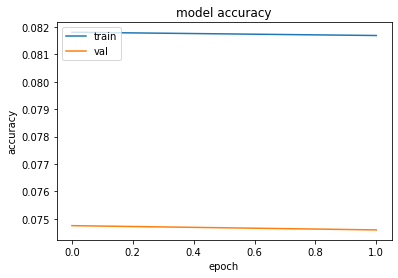

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(testgen)

47/47 [==============================] - 28s 585ms/step - loss: 0.0836


0.08364258706569672

In [ ]:
image = tf.keras.preprocessing.image.load_img('/content/ISIC_2019/NON_SEGMENTEES/TEST/MEL/ISIC_0000022_downsampled.JPG')
image_arr = tf.keras.preprocessing.image.img_to_array(image)
image_arr = tf.keras.preprocessing.image.smart_resize(image_arr, (224,224))
pred = model.predict(np.expand_dims(image_arr, 0))

In [ ]:
test_df.iloc[0]['Name']

'/content/ISIC_2019/NON_SEGMENTEES/TEST/MEL/ISIC_0000022_downsampled.JPG'

In [ ]:
np.sum(abs(X_testANN[0] - pred))

48.6287681371802

In [ ]:
pred

In [ ]:
X_testANN[0]

## ANN

In [ ]:
def get_features():
  ohe = OneHotEncoder()

  featuresNames = ['beta_quad_RGB', 'beta_quad_HSV', 'beta_quad_Lab', 'beta_quad_YCrCb',
                  'histos', 'histos_HSV', 'histos_Lab', 'histos_YCrCb',
                  'SPML_4_2', 'SPML_4_2_HSV', 'SPML_4_2_cielab', 'SPML_4_2_ycbcr',
                  'SPO', 'SP60_4']

  loader = DataLoader(featuresNames)
  X_train, y_train, X_test, y_test = loader.load(centering=True)

  ohe.fit(y_train.reshape((-1, 1)))
  y_trainOH = ohe.transform(y_train.reshape((-1, 1))).toarray()
  y_testOH = ohe.transform(y_test.reshape((-1, 1))).toarray()
  return X_train, y_trainOH, X_test, y_testOH

def get_HCANN():
  model = Sequential()
  #model.add(Dense(32, activation='relu'))
  model.add(Dense(16, input_dim=714, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC'])
  return model

X_trainANN, y_trainANN, X_testANN, y_testANN = get_features()

In [ ]:
hcann = get_HCANN()
hcann.load_weights('/content/drive/MyDrive/Stage_LIS/Weights/hcann.h5')

In [ ]:
image = tf.keras.preprocessing.image.load_img('/content/ISIC_0084395.jpg')
image_arr = tf.keras.preprocessing.image.img_to_array(image)
image_arr = tf.keras.preprocessing.image.smart_resize(image_arr, (224,224))
hcann(model(image_arr))
hcann(np.expand_dims(X_trainANN[0], 0))
#print(model(image_arr))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.7277653 , 0.27223468]], dtype=float32)>

              precision    recall  f1-score   support

    Mélanome       0.33      0.92      0.49       273
      Naevus       0.97      0.60      0.74      1260

    accuracy                           0.65      1533
   macro avg       0.65      0.76      0.61      1533
weighted avg       0.86      0.65      0.69      1533

ROC score on test set :  0.8679748822605966


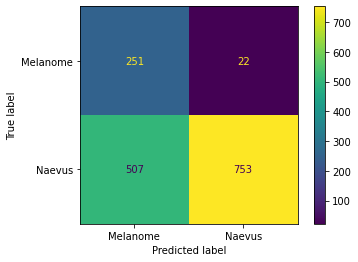

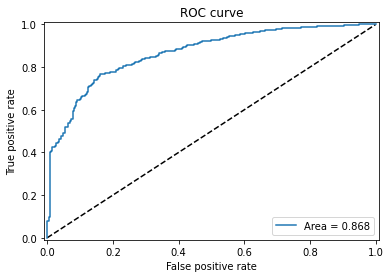

In [ ]:
y_predANN = hcann.predict(X_testANN)
visu_results(y_testANN, y_predANN, confidence=y_predANN)

# Outlier detection

In [ ]:
from sklearn.ensemble import IsolationForest

model = EfficientNetB2(include_top=False)
#model.load_weights('/content/drive/MyDrive/Stage_LIS/Weights/b2_fine.h5')

In [ ]:
def get_img(path):
  image = tf.keras.preprocessing.image.load_img(path)
  image_arr = tf.keras.preprocessing.image.img_to_array(image)
  return tf.keras.preprocessing.image.smart_resize(image_arr, (224,224))

path = '/content/ISIC_2019/NON_SEGMENTEES/TRAIN/NEV'
X_train = [model(get_img(img)) for img in [join(path,f) for f in listdir(path) if isfile(join(path, f))]]